# Uploading the Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

In [ ]:
# Uploading the whole dataset and making it into dataframe
df = pd.read_csv("/content/drive/MyDrive/MThesis/political_leaning.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MThesis/political_leaning.csv'

In [ ]:
# Uploading the already cleaned train and test dataset and making them into dataframes
X_trainval = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval.csv")
X_test2 = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2.csv")

y_trainval = X_trainval['political_leaning']
y_test = X_test2 ['political_leaning']

In [ ]:
# Getting size of train dataset
X_trainval.shape

(44343, 1318)

# Descriptives

In [ ]:
# Combining cleaned datasets to see their descriptives
df = pd.concat([X_trainval, X_test2])

In [ ]:
# After Data Cleaning Whole Dataset
unique_count = df['political_leaning'].value_counts()
unique_percent = df['political_leaning'].value_counts(normalize=True) * 100

print(unique_percent)

political_leaning
center    44.220203
right     30.424849
left      25.354948
Name: proportion, dtype: float64


In [ ]:
# For the Training Set
unique_count = X_trainval['political_leaning'].value_counts()
unique_percent = X_trainval['political_leaning'].value_counts(normalize=True) * 100

print(unique_percent)

political_leaning
center    44.063325
right     31.222515
left      24.714160
Name: proportion, dtype: float64


In [ ]:
# For the Testing Set
unique_count = X_test2['political_leaning'].value_counts()
unique_percent = X_test2['political_leaning'].value_counts(normalize=True) * 100

print(unique_percent)

political_leaning
center    44.863964
left      27.984453
right     27.151582
Name: proportion, dtype: float64


# Preprocessing

## Removing extra charcters and lowering the text

References: https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python

In [ ]:
# Function to keep only letters, numbers, spaces, and apostrophes, and to replace double spaces with single, and lower all text

import re
def preprocess(text):
    text = re.sub(r'[^\w\s\']',' ', text)
    text = re.sub(' +', ' ', text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*', 'URL', text, flags=re.MULTILINE)
    return text.strip().lower()

In [ ]:
# Applying the fuction and seeing how long it takes
import time
start = time.time()

df['processed_post'] = df['post'].apply(preprocess)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

This code took  0.47142569224039715  minutes


In [ ]:
# Saving it to the uptaded dataframe file
df.to_csv('/content/drive/MyDrive/MThesis/preprocess_df.csv',index = False)

## Language

In [ ]:
# Installing langadetect
!pip install langdetect

In [ ]:
# Detecting English language in posts and seeing how long does the code take
from langdetect import detect, DetectorFactory, LangDetectException
import pandas as pd
import time

start = time.time()

# Setting seed
DetectorFactory.seed = 29

# Function to detect English
def is_english(text):
    try:
        return detect(text) == 'en'
    except LangDetectException:
        return False  # In case the detection fails, assume it's not English

# Detecting language and filter for English posts
df['is_english'] = df['processed_post'].apply(is_english)
df = df[df['is_english']].drop('is_english', axis=1)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

This code took  18.918478083610534  minutes


In [ ]:
# Saving it to the uptaded dataframe file
df.to_csv('/content/drive/MyDrive/MThesis/preprocess_df.csv',index = False)

# Splitting the data

In [ ]:
# Splitting the data
from sklearn.model_selection import train_test_split
import pandas as pd

# Dropping dublicates for author IDs, therefore creating a DataFrame with unique author IDs and their political leanings
author_labels = df.drop_duplicates(subset=['auhtor_ID'])[['auhtor_ID', 'political_leaning']]

# Splitting the unique author IDs into training, validation, and test sets
train_ids, test_val_ids = train_test_split(author_labels['auhtor_ID'], test_size=0.4, stratify=author_labels['political_leaning'])
val_ids, test_ids = train_test_split(test_val_ids, test_size=0.5, stratify=author_labels.loc[author_labels['auhtor_ID'].isin(test_val_ids), 'political_leaning'])

# Filtering the original DataFrame based on the split author IDs
X_train = df[df['auhtor_ID'].isin(train_ids)]
X_val = df[df['auhtor_ID'].isin(val_ids)]
X_test = df[df['auhtor_ID'].isin(test_ids)]

# Creating y values
y_train = X_train['political_leaning']
y_val = X_val['political_leaning']
y_test = X_test['political_leaning']

# Checking the shapes of the resulting datasets
print(X_train.shape, X_val.shape, X_test.shape)

(33912, 18) (10431, 18) (10806, 18)


In [ ]:
# Combining train and validation dataset for one train dataset
X_trainval = pd.concat([X_val, X_train], axis=0)
y_trainval = pd.concat([y_val, y_train], axis=0)


# Reset the index after concatenation
X_trainval.reset_index(drop=True, inplace=True)
y_trainval.reset_index(drop=True, inplace=True)

In [ ]:
X_test2 = X_test.copy()

# Text representations

## Feature Engineering Baseline

### Average sentence lenght

In [ ]:
# Function to calculate the average length of a sentence
def calculate_avg_sentence_length(text):
    sentences = text.split('.')
    num_sentences = len(sentences) - 1  # Exclude the last empty string after the last period
    total_length = sum(len(sentence.split()) for sentence in sentences)
    if num_sentences > 0:
      return total_length / num_sentences
    else:
      return total_length

In [ ]:
# Applyting the function and creating new feature
import time
start = time.time()

X_train['avg_sentence_length'] = X_train['post'].apply(calculate_avg_sentence_length)
X_test['avg_sentence_length'] = X_test['post'].apply(calculate_avg_sentence_length)
X_val['avg_sentence_length'] = X_val['post'].apply(calculate_avg_sentence_length)


end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

This code took  0.12574091752370198  minutes


### Sentiment

In [ ]:
# Reading files and creating dictionary
opinion_lexicon = {}

with open('/content/drive/MyDrive/MThesis/opinion-lexicon-English/positive-words.txt', 'r') as f_pos:
    positive_words = [line.strip() for line in f_pos if not line.startswith(';') and line.strip()]

with open('/content/drive/MyDrive/MThesis/opinion-lexicon-English/negative-words.txt', 'r', encoding='latin-1') as f_neg:
    negative_words = [line.strip() for line in f_neg if not line.startswith(';') and line.strip()]

opinion_lexicon = {word: 1 for word in positive_words}
opinion_lexicon.update({word: -1 for word in negative_words})

In [ ]:
# Function to calculate sentiment score
def score_sentiment(text, opinion_lexicon):
    words = text.split()
    sentiment_score = 0

    for word in words:
        if word in opinion_lexicon:
            sentiment_score += opinion_lexicon[word]

    return sentiment_score

In [ ]:
# Creating new feature
import time
start = time.time()

X_train['sentiment'] = X_train['corrected_post'].apply(lambda x: score_sentiment(x, opinion_lexicon))
X_test['sentiment'] = X_test['corrected_post'].apply(lambda x: score_sentiment(x, opinion_lexicon))
X_val['sentiment'] = X_val['corrected_post'].apply(lambda x: score_sentiment(x, opinion_lexicon))

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

This code took  0.22068359851837158  minutes


In [ ]:
X_trainval = pd.concat([X_val, X_train], axis=0)
y_trainval = pd.concat([y_val, y_train], axis=0)


# Reset the index after concatenation
X_trainval.reset_index(drop=True, inplace=True)
y_trainval.reset_index(drop=True, inplace=True)

### Spelling mistakes

References: https://github.com/wolfgarbe/SymSpell/blob/master/SymSpell.FrequencyDictionary/en-80k.txt
https://symspellpy.readthedocs.io/en/latest/examples/lookup.html#basic-usage

In [ ]:
# Installing symspellpy
!pip install symspellpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 kB 11.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.4-cp310-cp310-linux_x86_64.whl size=187485 sha256=84638b1137188b2cad8acc4a3a8e6e5d06ccd68cb7603b733ff6da94734b0f06
  Stored in directory: /root/.cache/pip/wheels/4c/0f/10/c20d67cd765ee5b3666d759a307241bba0663135d6ee1c0072
Successfully built editdistpy


In [ ]:
# Creating function to correct posts
import pandas as pd
from symspellpy import SymSpell, Verbosity

sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
sym_spell.load_dictionary("/content/drive/MyDrive/MThesis/en-80k.txt", term_index=0, count_index=1)

def correct_spelling(input_term):
    # Ensure the input is a string
    if not isinstance(input_term, str):
        return input_term
    corrected_words = []
    for word in input_term.split():
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        corrected_words.append(suggestions[0].term if suggestions else word)
    return ' '.join(corrected_words)

In [ ]:
# Creating corrected posts column
import time
start = time.time()

# Apply the spelling correction word by word
X_train['corrected_post'] = X_train['processed_post'].apply(correct_spelling)
X_test['corrected_post'] = X_test['processed_post'].apply(correct_spelling)
X_val['corrected_post'] = X_val['processed_post'].apply(correct_spelling)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

<ipython-input-44-36d87de2b9c8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['corrected_post'] = X_train['processed_post'].apply(correct_spelling)
<ipython-input-44-36d87de2b9c8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['corrected_post'] = X_test['processed_post'].apply(correct_spelling)


This code took  13.027272168795268  minutes


<ipython-input-44-36d87de2b9c8>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['corrected_post'] = X_val['processed_post'].apply(correct_spelling)


In [ ]:
X_train.to_csv('/content/drive/MyDrive/MThesis/X_train.csv',index = False)
X_test.to_csv('/content/drive/MyDrive/MThesis/X_test.csv',index = False)
X_val.to_csv('/content/drive/MyDrive/MThesis/X_val.csv',index = False)

In [ ]:
import pandas as pd
from Levenshtein import distance as levenshtein_distance

# Function to calculate word-by-word Levenshtein distance and return the average of every entry
def calculate_average_word_distance(original, corrected):
    original_words = original.split()
    corrected_words = corrected.split()
    distances = []

    if len(original_words) != len(corrected_words):
        raise ValueError("Error")

    for orig_word, corr_word in zip(original_words, corrected_words):
        distances.append(levenshtein_distance(orig_word, corr_word))

    if distances:
        return sum(distances) / len(distances)
    else:
        return 0

In [ ]:
# Creating a new feature
import time
start = time.time()

X_train['average_word_distance'] = X_train.apply(lambda row: calculate_average_word_distance(row['processed_post'], row['corrected_post']), axis=1)
X_test['average_word_distance'] = X_test.apply(lambda row: calculate_average_word_distance(row['processed_post'], row['corrected_post']), axis=1)
X_val['average_word_distance'] = X_val.apply(lambda row: calculate_average_word_distance(row['processed_post'], row['corrected_post']), axis=1)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

This code took  0.883454434076945  minutes


In [ ]:
X_train.to_csv('/content/drive/MyDrive/MThesis/X_train.csv',index = False)
X_test.to_csv('/content/drive/MyDrive/MThesis/X_test.csv',index = False)
X_val.to_csv('/content/drive/MyDrive/MThesis/X_val.csv',index = False)

### Parts of speech

References: https://www.askpython.com/python/examples/pos-tagging-in-nlp-using-spacy

https://spacy.io/usage/linguistic-features

In [ ]:
# Installing
!pip install spacy
!pip install -U spacy
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 29.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Function to count each POS appearance in an entry
import spacy

def extract_pos_counts(df, text_column='post'):
    # Load the small English model
    nlp = spacy.load("en_core_web_sm")

    # List to store the tokens and pos tags
    token = []
    pos = []

    for sent in nlp.pipe(df[text_column]):
        if sent.has_annotation('DEP'):
            # Add the tokens present in the sentence to the token list
            token.append([word.text for word in sent])
            # Add the pos tags for each token to the pos list
            pos.append([word.pos_ for word in sent])

    df['pos'] = pos

    # Counting the number of a specific pos tag in each sentence
    df['nouns'] = df['pos'].apply(lambda x: x.count('NOUN'))
    df['verbs'] = df['pos'].apply(lambda x: x.count('VERB'))
    df['adjectives'] = df['pos'].apply(lambda x: x.count('ADJ'))
    df['punctuation'] = df['pos'].apply(lambda x: x.count('PUNCT'))
    df['proper_nouns'] = df['pos'].apply(lambda x: x.count('PROPN'))
    df['auxiliary_verbs'] = df['pos'].apply(lambda x: x.count('AUX'))
    df['adpositions'] = df['pos'].apply(lambda x: x.count('ADP'))
    df['symbols'] = df['pos'].apply(lambda x: x.count('SYM'))
    df['numbers'] = df['pos'].apply(lambda x: x.count('NUM'))
    return df

In [ ]:
# Getting POS trigrams for train dataset
from sklearn.feature_extraction.text import CountVectorizer
import time
start = time.time()

vectorizer = CountVectorizer(ngram_range=(3, 3), max_features=300)

X_train_post_cv = vectorizer.fit_transform(X_trainval['pos'])

X_train_cv_df = pd.DataFrame(X_train_post_cv.toarray(), columns=vectorizer.get_feature_names_out())

X_train_cv_df.reset_index(drop=True, inplace=True)
X_trainval.reset_index(drop=True, inplace=True)
X_trainval = pd.concat([X_trainval, X_train_cv_df], axis = 1)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

This code took  1.3698015530904135  minutes


In [ ]:
# Getting POS trigrams for test dataset
import numpy as np
import time
start = time.time()

X_test_post_cv = vectorizer.transform(X_test2['pos'].apply(lambda x: np.str_(x)))

X_test_cv_df = pd.DataFrame(X_test_post_cv.toarray(), columns=vectorizer.get_feature_names_out())

X_test_cv_df.reset_index(drop=True, inplace=True)
X_test2.reset_index(drop=True, inplace=True)
X_test2 = pd.concat([X_test2, X_test_cv_df], axis = 1)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

This code took  0.3280902902285258  minutes


In [ ]:
X_trainval.to_csv('/content/drive/MyDrive/MThesis/X_trainval.csv',index = False)
X_test2.to_csv('/content/drive/MyDrive/MThesis/X_test2.csv',index = False)

### Character trigrams

In [ ]:
# Installing scikit-learn
!pip install scikit-learn

In [ ]:
# Creating feature of character trigrams for train dataset
from sklearn.feature_extraction.text import CountVectorizer
import time
start = time.time()

vectorizer = CountVectorizer(analyzer='char', ngram_range=(3, 3), max_features=1000)

X_train_post_cv = vectorizer.fit_transform(X_trainval['post'])

X_train_cv_df = pd.DataFrame(X_train_post_cv.toarray(), columns=vectorizer.get_feature_names_out())

X_train_cv_df.reset_index(drop=True, inplace=True)
X_trainval.reset_index(drop=True, inplace=True)
X_trainval = pd.concat([X_trainval, X_train_cv_df], axis = 1)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

This code took  3.5327308138211566  minutes


In [ ]:
# Creating feature of character trigrams for test dataset

import time
start = time.time()

X_test_post_cv = vectorizer.transform(X_test2['post'].apply(lambda x: np.str_(x)))

# Convert to DataFrame to be used in the prediction
X_test_cv_df = pd.DataFrame(X_test_post_cv.toarray(), columns=vectorizer.get_feature_names_out())

X_test_cv_df.reset_index(drop=True, inplace=True)
X_test2.reset_index(drop=True, inplace=True)
X_test2 = pd.concat([X_test2, X_test_cv_df], axis = 1)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

This code took  0.8822653929392497  minutes


In [ ]:
X_trainval.to_csv('/content/drive/MyDrive/MThesis/X_trainval.csv',index = False)
X_test2.to_csv('/content/drive/MyDrive/MThesis/X_test2.csv',index = False)

## TF-IDF

In [ ]:
# Creating 100000 TF-IDF embeddings for train set
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words = 'english', max_features=10000)

X_train_post_tfidf = vectorizer.fit_transform(X_trainval['processed_post'])

X_trainval_tfidf = pd.DataFrame(X_train_post_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
X_trainval_tfidf.to_csv("/content/drive/MyDrive/MThesis/X_trainval_tfidf.csv", index=False)

In [ ]:
# Creating TF-IDF embeddings for test set
X_test_post_tfidf = vectorizer.transform(X_test2['processed_post'])

X_test2_tfidf = pd.DataFrame(X_test_post_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
X_test2_tfidf.to_csv("/content/drive/MyDrive/MThesis/X_test2_tfidf.csv", index=False)

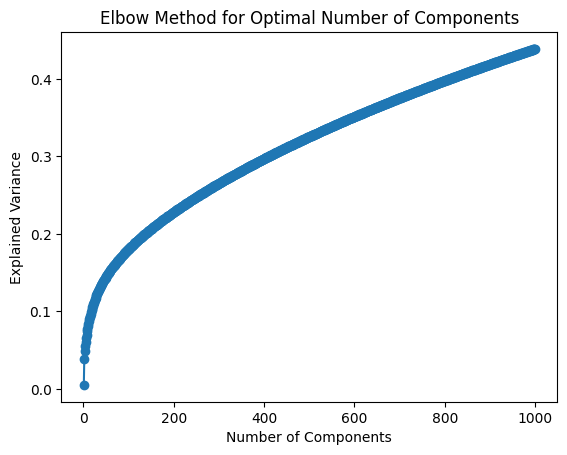

In [ ]:
# Drawing Explained variance graph for first 1000 TF-IDF values
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

X_array = X_trainval_tfidf.values

components = np.arange(1, 1000)
explained_variance = []

for n in components:
    svd = TruncatedSVD(n_components=n)
    svd.fit(X_array)
    explained_variance.append(svd.explained_variance_ratio_.sum())

plt.plot(components, explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.title('Elbow Method for Optimal Number of Components')
plt.show()


In [ ]:
# Based on the graph, reducing dimensions of TF-IDF to 70 for train dataset
from sklearn.decomposition import TruncatedSVD

n_components = 70

svd = TruncatedSVD(n_components)
tfidf_reduced = svd.fit_transform(X_trainval_tfidf)

In [ ]:
# Reducing dimenssions for test dataset
X_test_tfidf = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2_tfidf.csv")

X_test_reduced = svd.transform(X_test_tfidf)

In [ ]:
tfidf_reduced = pd.DataFrame(tfidf_reduced)
X_test_reduced = pd.DataFrame(X_test_reduced)

tfidf_reduced.to_csv("/content/drive/MyDrive/MThesis/X_trainval_tfidf_reduced.csv", index=False)
X_test_reduced.to_csv("/content/drive/MyDrive/MThesis/X_test2_tfidf_reduced.csv", index=False)

## Big Bird

References: https://huggingface.co/google/bigbird-roberta-base?library=true
https://huggingface.co/docs/transformers/en/model_doc/big_bird
https://github.com/SergeyKramp/mthesis-bigbird-embeddings/blob/master/feature_extractors/transformer_feature_extractor.py


In [ ]:
# Installing torch
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
# Creating a class to extract Big Bird embeddings
# (from https://github.com/SergeyKramp/mthesis-bigbird-embeddings/blob/master/feature_extractors/transformer_feature_extractor.py)

import torch
from transformers import AutoTokenizer, AutoModel
from typing import List
import numpy as np
from tqdm import tqdm


class TransformerFeatureExtractor:
    def __init__(self, model_name: str, max_length: int=2048):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.max_length = max_length
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def transform(self, X : List[str] or str, log_file=None) -> np.ndarray:
        X_tokenized = self._tokenize(X)
        X_tokenized_truncated = self._truncate_tokens(X_tokenized)
        X_tokenized_truncated_padded = self._pad_tokens(X_tokenized_truncated)

        assert all([len(x) == self.max_length for x in X_tokenized_truncated_padded])

        input_ids = self._convert_tokens_to_ids(X_tokenized_truncated_padded)
        attention_masks = self._create_attention_mask(input_ids)

        input_id_tensors = [torch.tensor(x).to(self.device) for x in input_ids]
        attention_mask_tensors = [torch.tensor(x).to(self.device) for x in attention_masks]

        self.model.to(self.device)
        self.model.eval()

        features = []

        with torch.no_grad():
            for input_ids, attention_masks in tqdm(zip(input_id_tensors, attention_mask_tensors),
                                                   total=len(input_id_tensors),
                                                   desc='Extracting features',
                                                   file=open(log_file, 'w') if log_file else None):
                outputs = self.model(input_ids.unsqueeze(0), attention_mask=attention_masks.unsqueeze(0))
                features.append(outputs['last_hidden_state'][:,0,:].cpu().numpy())

        self.model.to('cpu')
        torch.cuda.empty_cache()

        features = np.concatenate(features, axis=0)

        assert features.shape == (len(X), self.model.config.hidden_size)

        return features

    def _tokenize(self, X: List[str] or str) -> List[List[str]] or List[str]:

        if isinstance(X, str):
            X = X.replace('\n', self.tokenizer.sep_token)
            X = self.tokenizer.cls_token + X + self.tokenizer.sep_token

            return self.tokenizer.tokenize(X)

        tokens = []

        for x in X:
            x = x.replace('\n', self.tokenizer.sep_token)
            x = self.tokenizer.cls_token + x + self.tokenizer.sep_token
            tokens.append(self.tokenizer.tokenize(x))

        return tokens

    def _truncate_tokens(self, X: List[List[str]] or List[str]) -> List[List[str]] or List[str]:
        if isinstance(X, str):
            if len(X) > self.max_length:
                return X[:self.max_length -1] + [self.tokenizer.sep_token]

        return [x[:self.max_length -1] + [self.tokenizer.sep_token] if len(x) > self.max_length else x for x in X]

    def _pad_tokens(self, X: List[List[str]] or List[str]) -> List[List[str]] or List[str]:
        if isinstance(X[0], str):
            if len(X) < self.max_length:
                return X + [self.tokenizer.pad_token] * (self.max_length - len(X))

        return [x + [self.tokenizer.pad_token] * (self.max_length - len(x)) if len(x) < self.max_length else x for x in X]

    def _convert_tokens_to_ids(self, X: List[List[str]] or List[str]) -> List[List[int]] or List[int]:
        if isinstance(X[0], str):
            return self.tokenizer.convert_tokens_to_ids(X)

        return [self.tokenizer.convert_tokens_to_ids(x) for x in X]

    def _create_attention_mask(self, X: List[List[int]] or List[int]) -> List[List[int]] or List[int]:
        if isinstance(X[0], int):
            return [1 if x != self.tokenizer.pad_token_id else 0 for x in X]

        return [[1 if id != self.tokenizer.pad_token_id else 0 for id in x] for x in X]

In [ ]:
# Applying class to train dataset
import torch
from transformers import AutoTokenizer, AutoModel
from typing import List
import numpy as np
from tqdm import tqdm
import time

start = time.time()

texts = X_trainval['processed_post'].tolist()
model_name = "google/bigbird-roberta-base"
feature_extractor = TransformerFeatureExtractor(model_name=model_name)
embeddings = feature_extractor.transform(texts)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/846k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (4164 > 4096). Running this sequence through the model will result in indexing errors
Extracting features: 100%|██████████| 44343/44343 [1:23:45<00:00,  8.82it/s]


This code took  90.18450177907944  minutes


In [ ]:
X_trainval_bigbird = pd.DataFrame(embeddings)

In [ ]:
X_trainval_bigbird.to_csv("/content/drive/MyDrive/MThesis/X_trainval_bigbird.csv", index=False)

In [ ]:
# Applying class to test dataset

import torch
from transformers import AutoTokenizer, AutoModel
from typing import List
import numpy as np
from tqdm import tqdm
import time

start = time.time()

texts = X_test2['processed_post'].tolist()

model_name = "google/bigbird-roberta-base"
feature_extractor = TransformerFeatureExtractor(model_name=model_name)

embeddings = feature_extractor.transform(texts)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

Extracting features: 100%|██████████| 10806/10806 [20:22<00:00,  8.84it/s]


This code took  22.088640960057578  minutes


In [ ]:
X_test2_bigbird = pd.DataFrame(embeddings)

In [ ]:
X_test2_bigbird.to_csv("/content/drive/MyDrive/MThesis/X_test2_bigbird.csv", index=False)

## Word2Vec

Reference: https://github.com/PradipNichite/Youtube-Tutorials/blob/main/Yotutube_WordVectors.ipynb

In [ ]:
# Installing
!pip install --upgrade gensim -q
!pip install matplotlib -q

In [ ]:
# Importing libraries
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import spacy
import string

In [ ]:
import gensim.downloader as api
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
# Downloading Word2Vec dictionary
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Function to create Word2Vec embeddings
def sent_vec(sent):
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sent:
        if w in wv:
            ctr += 1
            wv_res += wv[w]
    wv_res = wv_res/ctr
    return wv_res

In [ ]:
# Tokenizer function
def spacy_tokenizer(sentence):
    doc = nlp(sentence)
    mytokens = [ word.lemma_.lower().strip() for word in doc ]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    return mytokens

In [ ]:
nlp = spacy.load("en_core_web_sm")
stop_words = nlp.Defaults.stop_words

In [ ]:
punctuations = string.punctuation

In [ ]:
# Applying the functions to train dataset
import time

start = time.time()

X_trainval['tokens'] = X_trainval['processed_post'].apply(spacy_tokenizer)
X_trainval['word2vec'] = X_trainval['tokens'].apply(sent_vec)

X_trainval.to_csv("/content/drive/MyDrive/MThesis/X_trainval_word2vec.csv", index=False)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

This code took  173.69383515516918  minutes


In [ ]:
# Applying the functions to test dataset
import time

start = time.time()

X_test2['tokens'] = X_test2['processed_post'].apply(spacy_tokenizer)
X_test2['word2vec'] = X_test2['tokens'].apply(sent_vec)

X_test2.to_csv("/content/drive/MyDrive/MThesis/X_test2_word2vec.csv", index=False)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

This code took  43.09192161957423  minutes


# Mayority baseline

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Creating a classifier that ignores input features and predicts majority class
baseline_class = DummyClassifier(strategy="most_frequent")

# Training the model
baseline_class.fit(X_trainval, y_trainval)

# Making predictions
baseline_pred = baseline_class.predict(X_test2)

# Calculateting baseline's accuracy and f-score
baseline_accuracy = accuracy_score(y_test, baseline_pred)
baseline_f1 = f1_score(y_test, baseline_pred, average = None)
baseline_f1_weigh = f1_score(y_test, baseline_pred, average = "weighted")
baseline_f1_mic = f1_score(y_test, baseline_pred, average = "micro")
baseline_f1_mac = f1_score(y_test, baseline_pred, average = "macro")
baseline_precision = precision_score(y_test, baseline_pred, average='weighted')
baseline_recall = recall_score(y_test, baseline_pred, average='weighted')


print("Baseline accuracy: ", baseline_accuracy)
print("Baseline f1 score: ", baseline_f1)
print("Baseline f1 (weighted) score: ",baseline_f1_weigh)
print("Baseline f1 (micro) score: ",baseline_f1_mic)
print("Baseline f1 (macro) score: ",baseline_f1_mac)
print("Baseline precision: ",baseline_precision)
print("Baseline recall: ",baseline_recall)

Baseline accuracy:  0.4486396446418656
Baseline f1 score:  [0.6193944 0.        0.       ]
Baseline f1 (weighted) score:  0.27788488529752964
Baseline f1 (micro) score:  0.4486396446418656
Baseline f1 (macro) score:  0.20646480132873388
Baseline precision:  0.20127753074437946
Baseline recall:  0.4486396446418656


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Learning algorithms

## Logistic Regression

### Without word embeddings

In [ ]:
# Importing files
import pandas as pd

X_trainval = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval.csv")
X_test2 = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2.csv")

y_train = X_trainval['political_leaning']
y_test = X_test2['political_leaning']

X_train_lg = X_trainval.drop(["auhtor_ID","post","political_leaning","processed_post","corrected_post", "pos"], axis=1)
X_test_lg = X_test2.drop(["auhtor_ID","post","political_leaning","processed_post","corrected_post", "pos"], axis=1)

In [ ]:
# Perfoming Logistic Regression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, cross_validate

clf = LogisticRegressionCV(cv=5, multi_class='multinomial', max_iter = 1000).fit(X_train_lg, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
# Cross Validation
import time
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.model_selection import cross_validate

import time
start = time.time()

scoring = {'accuracy': make_scorer(accuracy_score), 'f1_weighted': make_scorer(f1_score, average='weighted')}
scores = cross_validate(clf, X_train_lg, y_train, cv=5, scoring=scoring)

accuracy_scores = scores['test_accuracy']
f1_scores = scores['test_f1_weighted']

avg_accuracy = accuracy_scores.mean()
avg_f1_score = f1_scores.mean()

print("Accuracy scores:", accuracy_scores)
print("F1 weighted scores:", f1_scores)
print("Average accuracy:", avg_accuracy)
print("Average F1 score:", avg_f1_score)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

""" Results:
Accuracy scores: [0.40714849 0.50648326 0.41763446 0.39490302 0.4191475 ]
F1 weighted scores: [0.40259996 0.48574052 0.41366308 0.38653889 0.41090186]
Average accuracy: 0.42906334537194085
Average F1 score: 0.4198888623016682
This code took  495.0776556690534  minutes
"""


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy scores: [0.40714849 0.50648326 0.41763446 0.39490302 0.4191475 ]
F1 weighted scores: [0.40259996 0.48574052 0.41366308 0.38653889 0.41090186]
Average accuracy: 0.42906334537194085
Average F1 score: 0.4198888623016682
This code took  495.0776556690534  minutes


In [ ]:
# Performace on test set
from sklearn.metrics import classification_report, confusion_matrix
import time
start = time.time()
predictions = clf.predict(X_test_lg)

print(classification_report(y_test, predictions))

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

              precision    recall  f1-score   support

      center       0.50      0.59      0.54      4848
        left       0.40      0.29      0.34      3024
       right       0.44      0.44      0.44      2934

    accuracy                           0.46     10806
   macro avg       0.45      0.44      0.44     10806
weighted avg       0.46      0.46      0.46     10806

This code took  0.008181862036387126  minutes


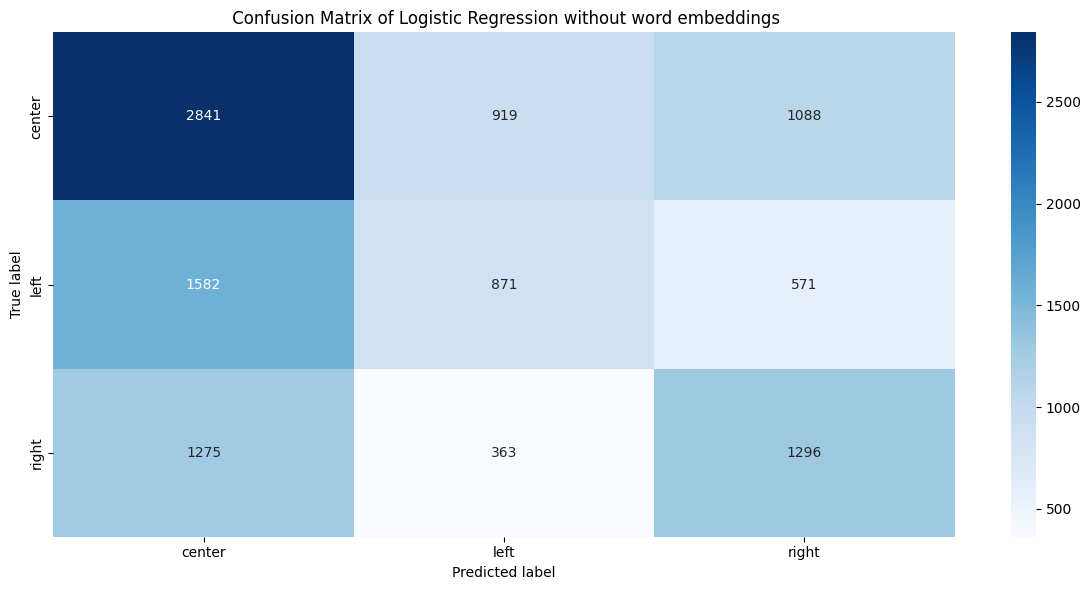

In [ ]:
# Confusion matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = np.unique(y_test)

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(" Confusion Matrix of Logistic Regression without word embeddings")

# Visualizing and saving the confusion matrix
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MThesis/cm_lg_without.jpg')
plt.show()

### + TF-IDF

In [ ]:
# Importing files
import pandas as pd

X_train_lg = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval_tfidf_reduced.csv")
X_test_lg = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2_tfidf_reduced.csv")

X_trainval = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval.csv")
X_test2 = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2.csv")

y_train = X_trainval['political_leaning']
y_test = X_test2['political_leaning']

In [ ]:
# Perfoming Logistic Regression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, cross_validate

clf = LogisticRegressionCV(cv=5, multi_class='multinomial', max_iter = 1000).fit(X_train_lg, y_train)

In [ ]:
# Cross Validation
import time
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.model_selection import cross_validate

import time
start = time.time()

scoring = {'accuracy': make_scorer(accuracy_score), 'f1_weighted': make_scorer(f1_score, average='weighted')}
scores = cross_validate(clf, X_train_lg, y_train, cv=5, scoring=scoring)

accuracy_scores = scores['test_accuracy']
f1_scores = scores['test_f1_weighted']

avg_accuracy = accuracy_scores.mean()
avg_f1_score = f1_scores.mean()

print("Accuracy scores:", accuracy_scores)
print("F1 weighted scores:", f1_scores)
print("Average accuracy:", avg_accuracy)
print("Average F1 score:", avg_f1_score)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

"""Results
Accuracy scores: [0.45743601 0.44063592 0.45055812 0.41350925 0.45410465]
F1 weighted scores: [0.41010332 0.26954765 0.39917156 0.35544668 0.38648071]
Average accuracy: 0.44324879048128646
Average F1 score: 0.36414998471302595
This code took  2.782501737276713  minutes
"""

Accuracy scores: [0.45743601 0.44063592 0.45055812 0.41350925 0.45410465]
F1 weighted scores: [0.41010332 0.26954765 0.39917156 0.35544668 0.38648071]
Average accuracy: 0.44324879048128646
Average F1 score: 0.36414998471302595
This code took  2.782501737276713  minutes


In [ ]:
# Performace on test set
from sklearn.metrics import classification_report, confusion_matrix
import time
start = time.time()
predictions = clf.predict(X_test_lg)

print(classification_report(y_test, predictions))

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

              precision    recall  f1-score   support

      center       0.49      0.83      0.62      4848
        left       0.45      0.09      0.15      3024
       right       0.52      0.36      0.42      2934

    accuracy                           0.49     10806
   macro avg       0.49      0.42      0.40     10806
weighted avg       0.49      0.49      0.43     10806

This code took  0.0065983931223551435  minutes


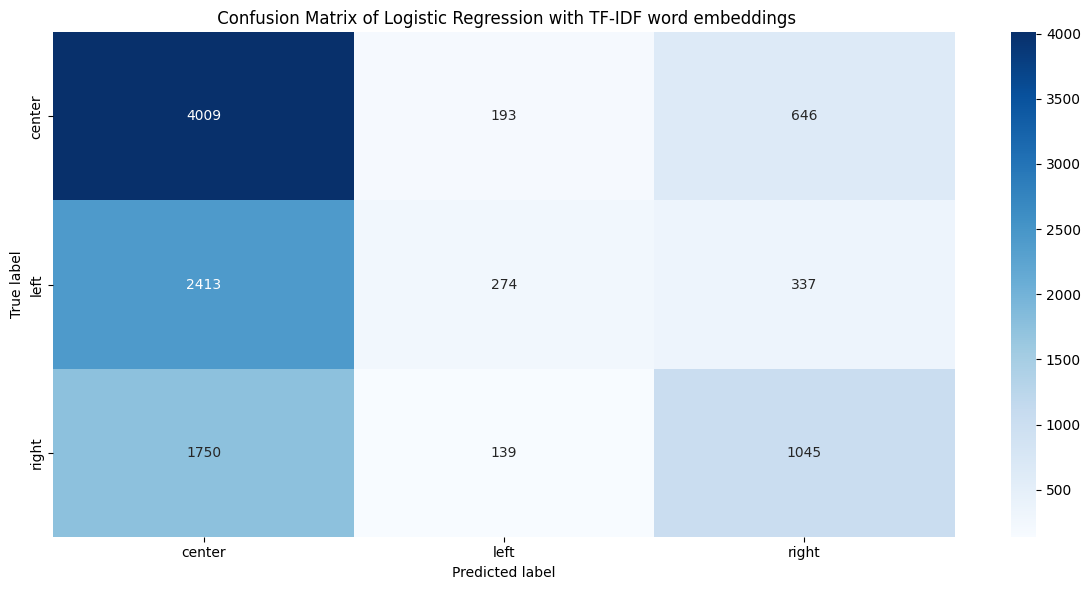

In [ ]:
# Confusion matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = np.unique(y_test)

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(" Confusion Matrix of Logistic Regression with TF-IDF word embeddings")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MThesis/cm_lg_tfidf.jpg')
plt.show()

### + Word2Vec

In [ ]:
# Importing files
X_train_lg = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval_word2vec.csv")
X_test_lg = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2_word2vec.csv")

def convert_to_float_list(float_str):
    float_str = float_str.replace('[', '').replace(']', '').split()
    float_list = [float(value) for value in float_str]
    return float_list

X_train_lg['vec'] = X_train_lg['word2vec'].apply(convert_to_float_list)
X_test_lg['vec'] = X_test_lg['word2vec'].apply(convert_to_float_list)

y_train_pd = X_train_lg['political_leaning']
X_train_lg = X_train_lg['vec'].to_list()
y_train = y_train_pd.values.tolist()

y_test_pd = X_test_lg['political_leaning']
X_test_lg = X_test_lg['vec'].to_list()
y_test = y_test_pd.values.tolist()

In [ ]:
# Performing Logistic Regression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, cross_validate

clf = LogisticRegressionCV(cv=5, multi_class='multinomial', max_iter = 1000).fit(X_train_lg, y_train)

In [ ]:
# Cross Validation
import time
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.model_selection import cross_validate

import time
start = time.time()

scoring = {'accuracy': make_scorer(accuracy_score), 'f1_weighted': make_scorer(f1_score, average='weighted')}
scores = cross_validate(clf, X_train_lg, y_train, cv=5, scoring=scoring)

accuracy_scores = scores['test_accuracy']
f1_scores = scores['test_f1_weighted']

avg_accuracy = accuracy_scores.mean()
avg_f1_score = f1_scores.mean()

print("Accuracy scores:", accuracy_scores)
print("F1 weighted scores:", f1_scores)
print("Average accuracy:", avg_accuracy)
print("Average F1 score:", avg_f1_score)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

"""Results:
Accuracy scores: [0.43003721 0.44063592 0.44063592 0.44068561 0.44057285]
F1 weighted scores: [0.37214811 0.26954765 0.26954765 0.26959915 0.26948229]
Average accuracy: 0.4385135022766349
Average F1 score: 0.2900649713027815
This code took  17.683087889353434  minutes
"""

Accuracy scores: [0.43003721 0.44063592 0.44063592 0.44068561 0.44057285]
F1 weighted scores: [0.37214811 0.26954765 0.26954765 0.26959915 0.26948229]
Average accuracy: 0.4385135022766349
Average F1 score: 0.2900649713027815
This code took  17.683087889353434  minutes


In [ ]:
# Perfomance on test data
from sklearn.metrics import classification_report, confusion_matrix
import time
start = time.time()
predictions = clf.predict(X_test_lg)

print(classification_report(y_test, predictions))

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

              precision    recall  f1-score   support

      center       0.47      0.88      0.61      4848
        left       0.35      0.04      0.06      3024
       right       0.48      0.24      0.32      2934

    accuracy                           0.47     10806
   macro avg       0.43      0.38      0.33     10806
weighted avg       0.44      0.47      0.38     10806

This code took  0.0062943021456400555  minutes


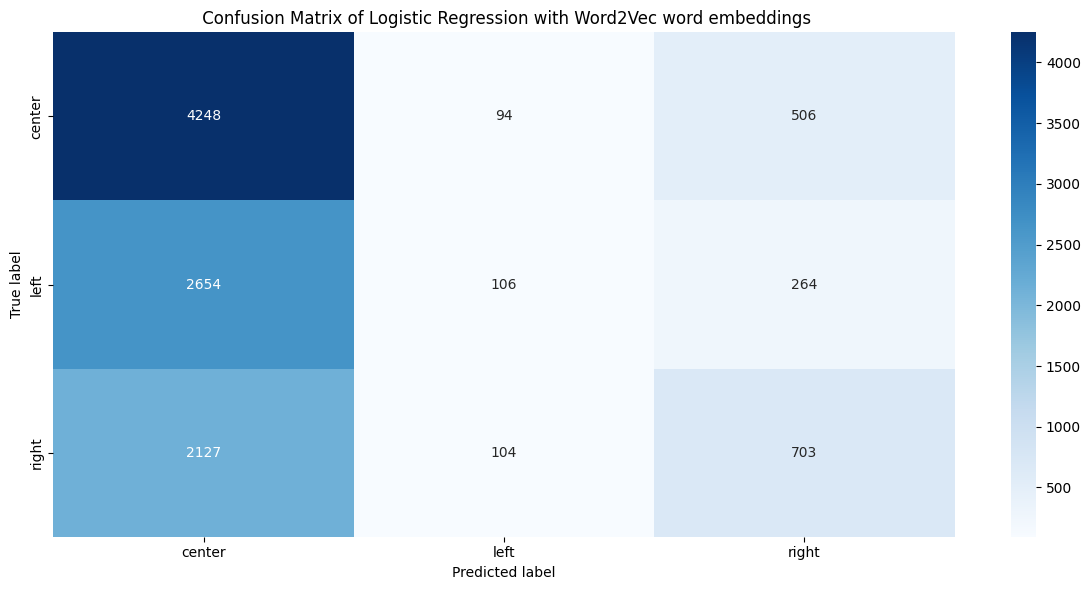

In [ ]:
# Confusion matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = np.unique(y_test)

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(" Confusion Matrix of Logistic Regression with Word2Vec word embeddings")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MThesis/cm_lg_word2vec.jpg')
plt.show()

### + Big Bird

In [ ]:
# Getting the files
X_train_lg = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval_bigbird.csv")
X_test_lg = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2_bigbird.csv")

X_trainval = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval.csv")
X_test2 = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2.csv")

y_train = X_trainval['political_leaning']
y_test = X_test2['political_leaning']

In [ ]:
# Performing Logistic Regression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, cross_validate

clf = LogisticRegressionCV(cv=5, multi_class='multinomial', max_iter = 1000).fit(X_train_lg, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
# Cross Validation
import time
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.model_selection import cross_validate

import time
start = time.time()

scoring = {'accuracy': make_scorer(accuracy_score), 'f1_weighted': make_scorer(f1_score, average='weighted')}
scores = cross_validate(clf, X_train_lg, y_train, cv=5, scoring=scoring)

accuracy_scores = scores['test_accuracy']
f1_scores = scores['test_f1_weighted']

avg_accuracy = accuracy_scores.mean()
avg_f1_score = f1_scores.mean()

print("Accuracy scores:", accuracy_scores)
print("F1 weighted scores:", f1_scores)
print("Average accuracy:", avg_accuracy)
print("Average F1 score:", avg_f1_score)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

"""Results:
Accuracy scores: [0.43341978 0.44074868 0.46183335 0.4030221  0.43662607]
F1 weighted scores: [0.37369494 0.26979417 0.41356894 0.34230914 0.382702  ]
Average accuracy: 0.43512999544871367
Average F1 score: 0.35641384005465754
This code took  120.74225990374883  minutes
"""

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Accuracy scores: [0.43341978 0.44074868 0.46183335 0.4030221  0.43662607]
F1 weighted scores: [0.37369494 0.26979417 0.41356894 0.34230914 0.382702  ]
Average accuracy: 0.43512999544871367
Average F1 score: 0.35641384005465754
This code took  120.74225990374883  minutes


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import time
start = time.time()
predictions = clf.predict(X_test_lg)

# print classification report
print(classification_report(y_test, predictions))

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

              precision    recall  f1-score   support

      center       0.47      0.81      0.60      4848
        left       0.37      0.06      0.11      3024
       right       0.45      0.30      0.36      2934

    accuracy                           0.46     10806
   macro avg       0.43      0.39      0.35     10806
weighted avg       0.44      0.46      0.40     10806

This code took  0.0073879400889078775  minutes


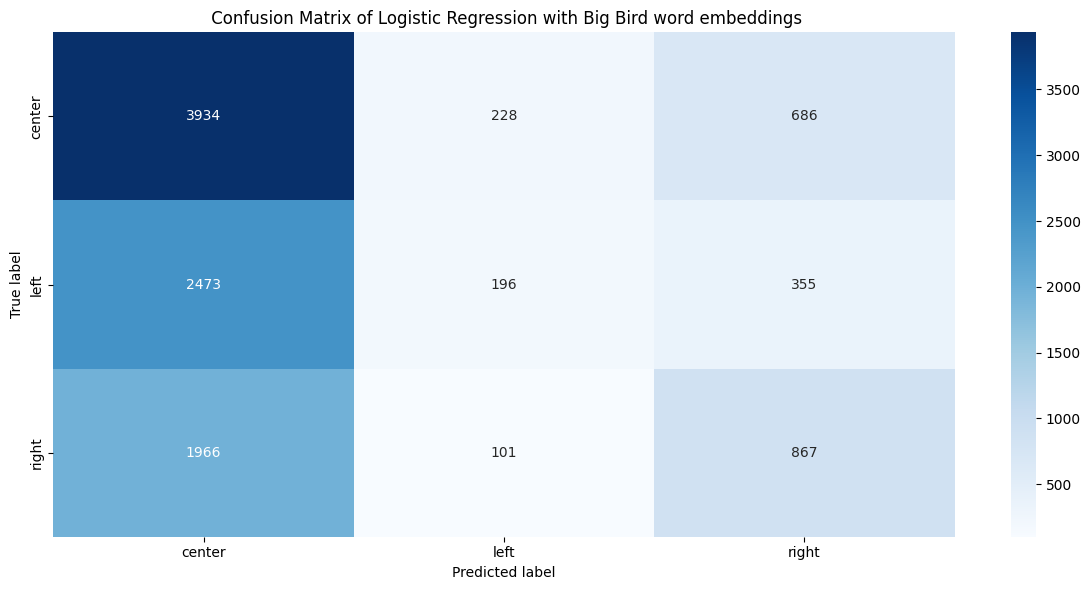

In [ ]:
# Confusion matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = np.unique(y_test)

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(" Confusion Matrix of Logistic Regression with Big Bird word embeddings")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MThesis/cm_lg_bigbird.jpg')
plt.show()

## SVM

### Without word embeddings

In [ ]:
# Get the data frame
X_train_svm = X_trainval.drop(["auhtor_ID","post","political_leaning","processed_post","corrected_post", "pos"], axis=1)
X_test_svm = X_test2.drop(["auhtor_ID","post","political_leaning","processed_post","corrected_post", "pos"], axis=1)

y_train = X_trainval['political_leaning']
y_test = X_test2['political_leaning']

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, f1_score
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer, accuracy_score, f1_score

In [ ]:
# Create an SVC model and cross validation
svc = SVC()

scoring = {'accuracy': make_scorer(accuracy_score), 'f1_weighted': make_scorer(f1_score, average='weighted')}

scores = cross_validate(svc, X_train_svm, y_train, cv=5, scoring=scoring)

accuracy_scores = scores['test_accuracy']
f1_scores = scores['test_f1_weighted']

avg_accuracy = accuracy_scores.mean()
avg_f1_score = f1_scores.mean()

print("Accuracy scores:", accuracy_scores)
print("F1 weighted scores:", f1_scores)
print("Average accuracy:", avg_accuracy)
print("Average F1 score:", avg_f1_score)

"""Took about one hour
Accuracy scores: [0.40669749 0.48765362 0.4125606  0.40448805 0.41114118]
F1 weighted scores: [0.38138648 0.41996203 0.37788892 0.36021741 0.37769898]
Average accuracy: 0.4245081887299286
Average F1 score: 0.3834307628674699
"""

Accuracy scores: [0.40669749 0.48765362 0.4125606  0.40448805 0.41114118]
F1 weighted scores: [0.38138648 0.41996203 0.37788892 0.36021741 0.37769898]


In [ ]:
# Results on test dataset
import time
start = time.time()

svc.fit(X_train_svm, y_train)
predictions = svc.predict(X_test_svm)
print(classification_report(y_test, predictions))

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

              precision    recall  f1-score   support

      center       0.48      0.71      0.57      4848
        left       0.42      0.15      0.22      3024
       right       0.46      0.40      0.43      2934

    accuracy                           0.47     10806
   macro avg       0.45      0.42      0.41     10806
weighted avg       0.46      0.47      0.43     10806

This code took  28.117362662156424  minutes


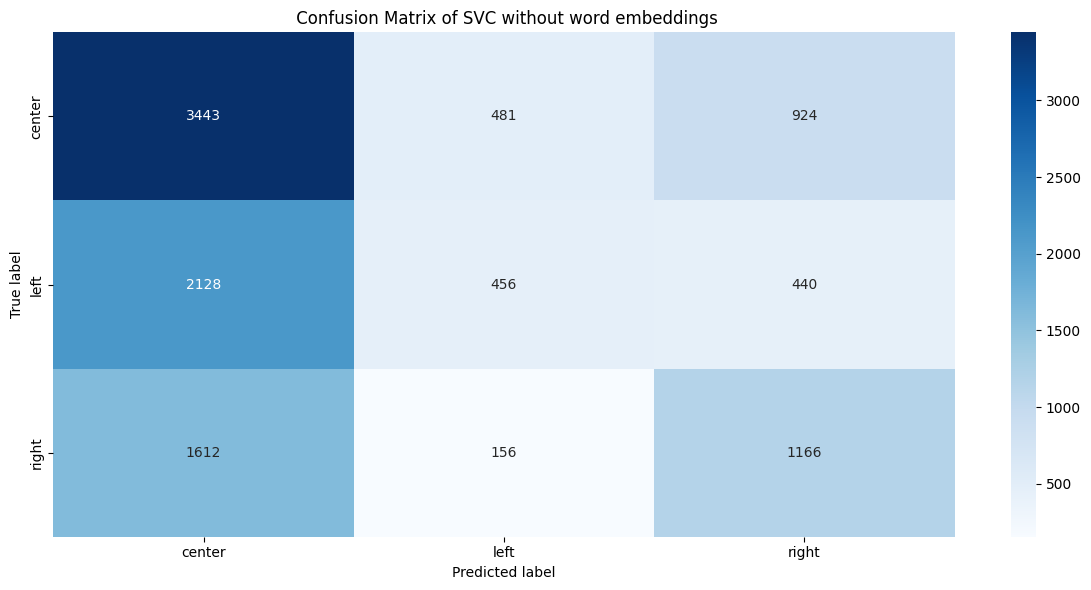

In [ ]:
# Confusion matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = np.unique(y_test)

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(" Confusion Matrix of SVC without word embeddings")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MThesis/cm_svc_without.jpg')
plt.show()

### + TF-IDF

In [ ]:
# Getting the files
import pandas as pd

X_train_svm = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval_tfidf_reduced.csv")
X_test_svm = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2_tfidf_reduced.csv")

X_trainval = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval.csv")
X_test2 = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2.csv")

y_train = X_trainval['political_leaning']
y_test = X_test2['political_leaning']

In [ ]:
# Importing the libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, f1_score
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer, accuracy_score, f1_score
import matplotlib.pyplot as plt

In [ ]:
# Creating SVC model and cross validation
import time
start = time.time()

svc = SVC()
scoring = {'accuracy': make_scorer(accuracy_score), 'f1_weighted': make_scorer(f1_score, average='weighted')}

scores = cross_validate(svc, X_train_svm, y_train, cv=5, scoring=scoring)

accuracy_scores = scores['test_accuracy']
f1_scores = scores['test_f1_weighted']

avg_accuracy = accuracy_scores.mean()
avg_f1_score = f1_scores.mean()

print("Accuracy scores:", accuracy_scores)
print("F1 weighted scores:", f1_scores)
print("Average accuracy:", avg_accuracy)
print("Average F1 score:", avg_f1_score)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

"""Results:
Accuracy scores: [0.44537152 0.4714173  0.42191904 0.41565178 0.45737483]
F1 weighted scores: [0.4361923  0.43388105 0.41443969 0.39588915 0.43640902]
Average accuracy: 0.44234689427472185
Average F1 score: 0.42336224397275524
This code took  8.673768532276153  minutes
"""

Accuracy scores: [0.44537152 0.4714173  0.42191904 0.41565178 0.45737483]
F1 weighted scores: [0.4361923  0.43388105 0.41443969 0.39588915 0.43640902]
Average accuracy: 0.44234689427472185
Average F1 score: 0.42336224397275524
This code took  8.673768532276153  minutes


In [ ]:
# Perfomance on test dataset
import time
start = time.time()

svc.fit(X_train_svm, y_train)
predictions = svc.predict(X_test_svm)
print(classification_report(y_test, predictions))

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

              precision    recall  f1-score   support

      center       0.50      0.69      0.58      4848
        left       0.43      0.19      0.26      3024
       right       0.44      0.41      0.43      2934

    accuracy                           0.48     10806
   macro avg       0.46      0.43      0.43     10806
weighted avg       0.46      0.48      0.45     10806

This code took  2.9297571142514545  minutes


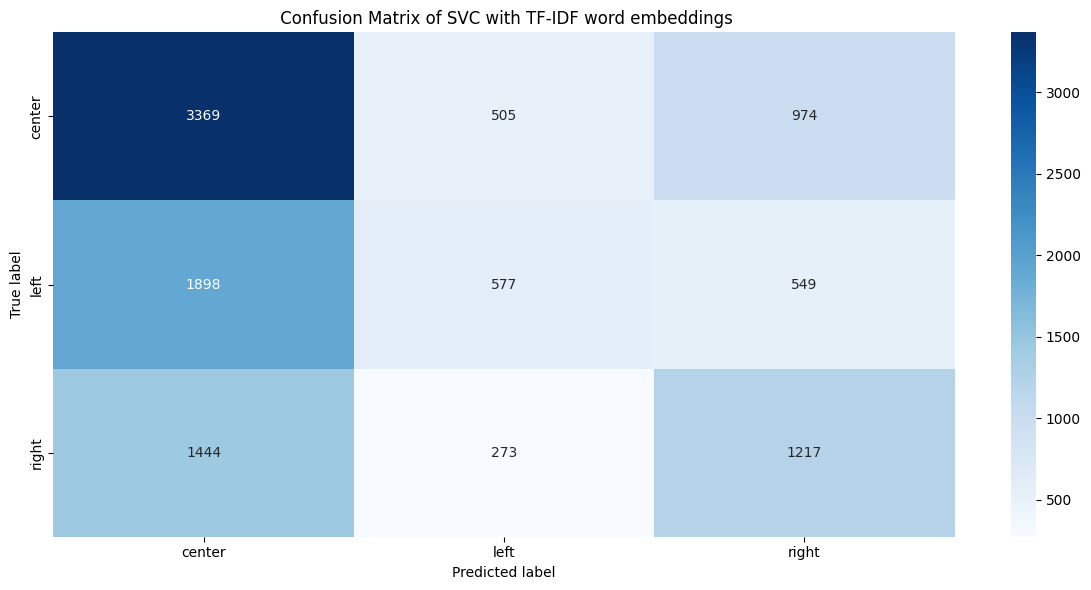

In [ ]:
# Confusion matrix
import numpy as np
import seaborn as sns

class_labels = np.unique(y_test)

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(" Confusion Matrix of SVC with TF-IDF word embeddings")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MThesis/cm_svc_tdfid.jpg')
plt.show()

### + Word2Vec

In [ ]:
#Getting the data frame
import pandas as pd

X_train_svm = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval_word2vec.csv")
X_test_svm = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2_word2vec.csv")

def convert_to_float_list(float_str):
    float_str = float_str.replace('[', '').replace(']', '').split()
    float_list = [float(value) for value in float_str]
    return float_list

# Apply the function to the entire column
X_train_svm['vec'] = X_train_svm['word2vec'].apply(convert_to_float_list)
X_test_svm['vec'] = X_test_svm['word2vec'].apply(convert_to_float_list)

y_train_pd = X_train_svm['political_leaning']
X_train_svm = X_train_svm['vec'].to_list()
y_train = y_train_pd.values.tolist()

y_test_pd = X_test_svm['political_leaning']
X_test_svm = X_test_svm['vec'].to_list()
y_test = y_test_pd.values.tolist()

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, f1_score
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer, accuracy_score, f1_score
import matplotlib.pyplot as plt

In [ ]:
# Creatting SVC model and cross validation
import time
start = time.time()

svc = SVC()

scoring = {'accuracy': make_scorer(accuracy_score), 'f1_weighted': make_scorer(f1_score, average='weighted')}
scores = cross_validate(svc, X_train_svm, y_train, cv=5, scoring=scoring)

accuracy_scores = scores['test_accuracy']
f1_scores = scores['test_f1_weighted']

avg_accuracy = accuracy_scores.mean()
avg_f1_score = f1_scores.mean()

print("Accuracy scores:", accuracy_scores)
print("F1 weighted scores:", f1_scores)
print("Average accuracy:", avg_accuracy)
print("Average F1 score:", avg_f1_score)


end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

"""Results:
Accuracy scores: [0.44086143 0.4888939  0.46521592 0.42828146 0.43053676]
F1 weighted scores: [0.4242813  0.42417657 0.45085239 0.40264837 0.40434689]
Average accuracy: 0.4507578941982821
Average F1 score: 0.42126110237385417
This code took  42.62674868106842  minutes
"""

Accuracy scores: [0.44086143 0.4888939  0.46521592 0.42828146 0.43053676]
F1 weighted scores: [0.4242813  0.42417657 0.45085239 0.40264837 0.40434689]
Average accuracy: 0.4507578941982821
Average F1 score: 0.42126110237385417
This code took  42.62674868106842  minutes


In [ ]:
# Perfomance on test dataset
import time
start = time.time()
svc = SVC()

svc.fit(X_train_svm, y_train)
predictions = svc.predict(X_test_svm)
print(classification_report(y_test, predictions))

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

              precision    recall  f1-score   support

      center       0.50      0.73      0.59      4848
        left       0.43      0.17      0.24      3024
       right       0.43      0.38      0.40      2934

    accuracy                           0.48     10806
   macro avg       0.45      0.42      0.41     10806
weighted avg       0.46      0.48      0.44     10806

This code took  12.942814048131307  minutes


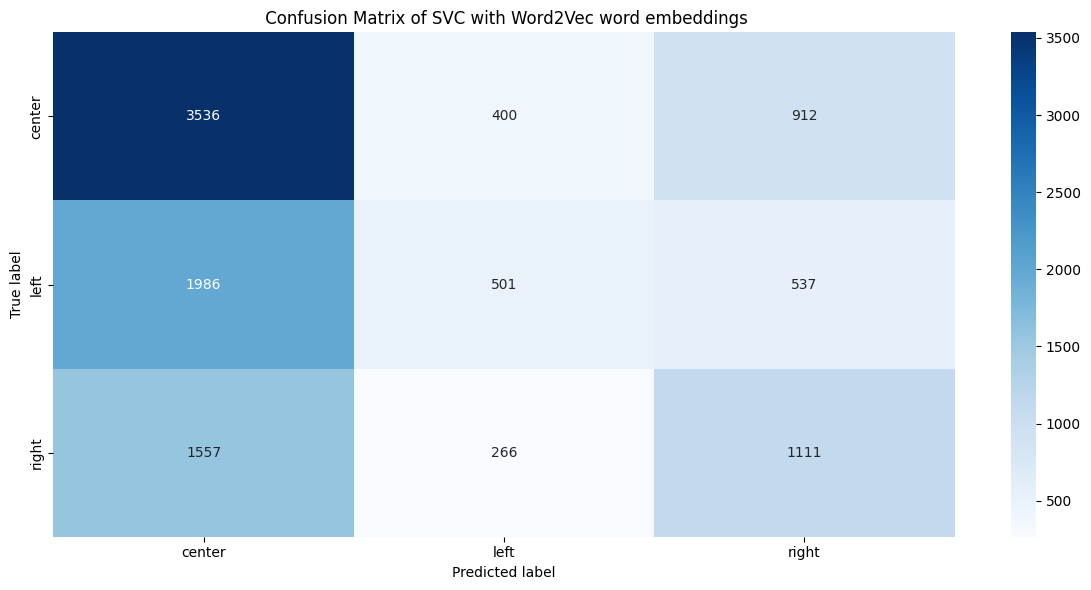

In [ ]:
# Confusion matrix
import numpy as np
import seaborn as sns

class_labels = np.unique(y_test)

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(" Confusion Matrix of SVC with Word2Vec word embeddings")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MThesis/cm_svc_word2vec.jpg')
plt.show()

### + Big Bird

In [ ]:
# Getting the dataframes
X_train_svm = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval_bigbird.csv")
X_test_svm = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2_bigbird.csv")

X_trainval = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval.csv")
X_test2 = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2.csv")

y_train = X_trainval['political_leaning']
y_test = X_test2['political_leaning']

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, f1_score
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, f1_score

In [ ]:
# Creating SVC model and cross validation
import time
start = time.time()

svc = SVC()

scoring = {'accuracy': make_scorer(accuracy_score), 'f1_weighted': make_scorer(f1_score, average='weighted')}

scores = cross_validate(svc, X_train_svm, y_train, cv=5, scoring=scoring)

accuracy_scores = scores['test_accuracy']
f1_scores = scores['test_f1_weighted']

avg_accuracy = accuracy_scores.mean()
avg_f1_score = f1_scores.mean()

print("Accuracy scores:", accuracy_scores)
print("F1 weighted scores:", f1_scores)
print("Average accuracy:", avg_accuracy)
print("Average F1 score:", avg_f1_score)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

"""Results:
Accuracy scores: [0.42902244 0.45980381 0.45236216 0.40877312 0.43854308]
F1 weighted scores: [0.36257621 0.31605547 0.37636797 0.33351514 0.37077468]
Average accuracy: 0.437700920423792
Average F1 score: 0.3518578932225659
This code took  109.08534046411515  minutes
"""

Accuracy scores: [0.42902244 0.45980381 0.45236216 0.40877312 0.43854308]
F1 weighted scores: [0.36257621 0.31605547 0.37636797 0.33351514 0.37077468]
Average accuracy: 0.437700920423792
Average F1 score: 0.3518578932225659
This code took  109.08534046411515  minutes


In [ ]:
# Perfomance on test dataset
import time
start = time.time()
svc = SVC()

svc.fit(X_train_svm, y_train)
predictions = svc.predict(X_test_svm)
print(classification_report(y_test, predictions))

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

              precision    recall  f1-score   support

      center       0.47      0.87      0.61      4848
        left       0.36      0.03      0.05      3024
       right       0.45      0.24      0.31      2934

    accuracy                           0.46     10806
   macro avg       0.43      0.38      0.32     10806
weighted avg       0.43      0.46      0.37     10806

This code took  35.70769873857498  minutes


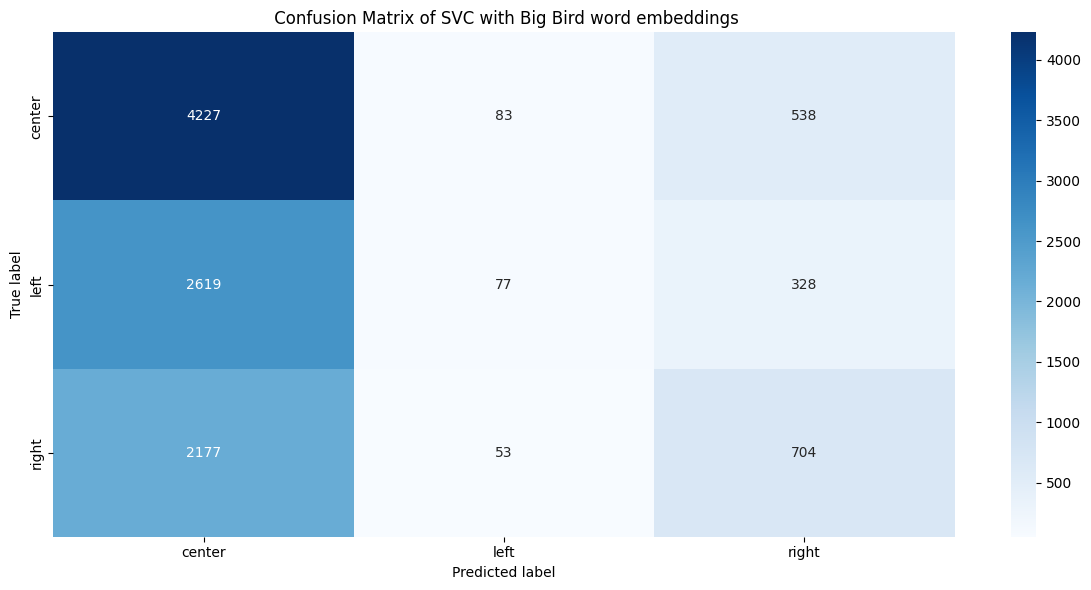

In [ ]:
# Confusion matrix
import numpy as np
import seaborn as sns

class_labels = np.unique(y_test)

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(" Confusion Matrix of SVC with Big Bird word embeddings")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MThesis/cm_svc_bigbird.jpg')
plt.show()

## GBDT

### + Without Word Embeddings

In [ ]:
# Getting dataframes
import pandas as pd

X_trainval = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval.csv")
X_test2 = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2.csv")

X_train_gbdt = X_trainval.drop(["auhtor_ID","post","political_leaning","processed_post","corrected_post", "pos"], axis=1)
X_test_gbdt = X_test2.drop(["auhtor_ID","post","political_leaning","processed_post","corrected_post", "pos"], axis=1)

y_train = X_trainval['political_leaning']
y_test = X_test2['political_leaning']

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, f1_score
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [ ]:
# Creating GBDT model and cross validation
import time
start = time.time()

clf = GradientBoostingClassifier()

scoring = {'accuracy': make_scorer(accuracy_score), 'f1_weighted': make_scorer(f1_score, average='weighted')}

scores = cross_validate(clf, X_train_gbdt, y_train, cv=5, scoring=scoring)

accuracy_scores = scores['test_accuracy']
f1_scores = scores['test_f1_weighted']

avg_accuracy = accuracy_scores.mean()
avg_f1_score = f1_scores.mean()

print("Accuracy scores:", accuracy_scores)
print("F1 weighted scores:", f1_scores)
print("Average accuracy:", avg_accuracy)
print("Average F1 score:", avg_f1_score)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

"""Results:
Accuracy scores: [0.40320216 0.45957831 0.41188409 0.41779432 0.39230943]
F1 weighted scores: [0.38180113 0.40558715 0.37705345 0.37759031 0.36820774]
Average accuracy: 0.41695366115106103
Average F1 score: 0.38204795584649365
This code took  106.47184511025746  minutes
"""

Accuracy scores: [0.40320216 0.45957831 0.41188409 0.41779432 0.39230943]
F1 weighted scores: [0.38180113 0.40558715 0.37705345 0.37759031 0.36820774]
Average accuracy: 0.41695366115106103
Average F1 score: 0.38204795584649365
This code took  106.47184511025746  minutes


In [ ]:
# Performance on test dataset
import time
start = time.time()

clf.fit(X_train_gbdt, y_train)
predictions = clf.predict(X_test_gbdt)
print(classification_report(y_test, predictions))

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

              precision    recall  f1-score   support

      center       0.47      0.69      0.56      4848
        left       0.35      0.15      0.21      3024
       right       0.46      0.38      0.42      2934

    accuracy                           0.46     10806
   macro avg       0.43      0.41      0.40     10806
weighted avg       0.43      0.46      0.42     10806

This code took  25.501268672943116  minutes


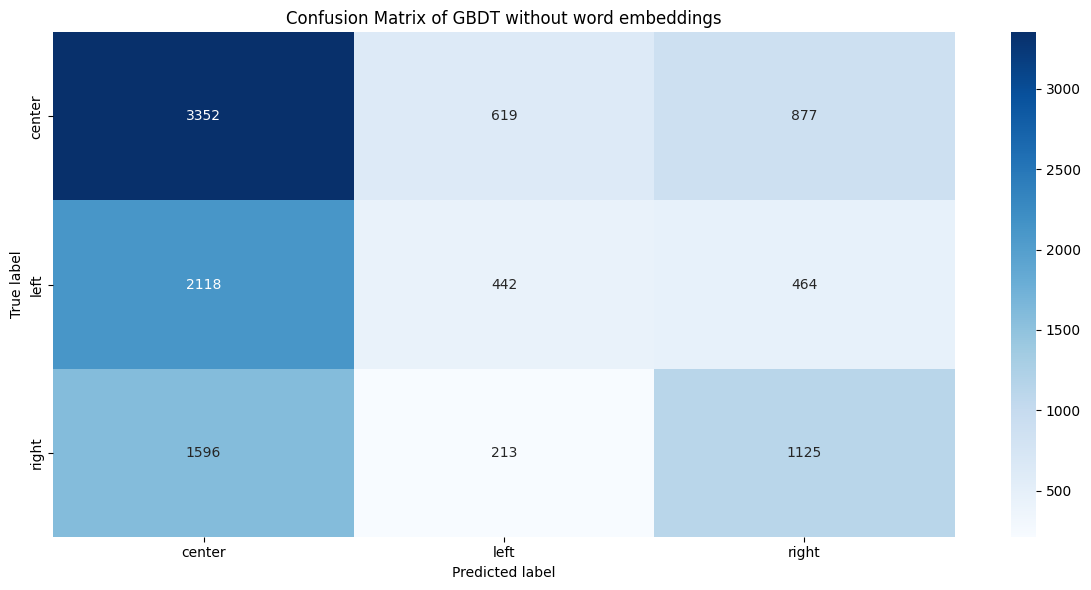

In [ ]:
# Confusion matrix
import numpy as np
import seaborn as sns

class_labels = np.unique(y_test)

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Confusion Matrix of GBDT without word embeddings")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MThesis/cm_gbdt_without.jpg')
plt.show()

### + TF-IDF

In [ ]:
#Getting the data frame
import pandas as pd

X_train_gbdt = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval_tfidf_reduced.csv")
X_test_gbdt = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2_tfidf_reduced.csv")

X_trainval = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval.csv")
X_test2 = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2.csv")

y_train = X_trainval['political_leaning']
y_test = X_test2['political_leaning']

In [ ]:
# Importing the libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, f1_score
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [ ]:
# Creating the GBDT model and cross validation
import time
start = time.time()

clf = GradientBoostingClassifier()

scoring = {'accuracy': make_scorer(accuracy_score), 'f1_weighted': make_scorer(f1_score, average='weighted')}
scores = cross_validate(clf, X_train_gbdt, y_train, cv=5, scoring=scoring)

accuracy_scores = scores['test_accuracy']
f1_scores = scores['test_f1_weighted']

avg_accuracy = accuracy_scores.mean()
avg_f1_score = f1_scores.mean()

print("Accuracy scores:", accuracy_scores)
print("F1 weighted scores:", f1_scores)
print("Average accuracy:", avg_accuracy)
print("Average F1 score:", avg_f1_score)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

"""Results:
Accuracy scores: [0.45044537 0.47615289 0.44300372 0.41576455 0.42456022]
F1 weighted scores: [0.42879298 0.4233277  0.42654346 0.38817568 0.39213603]
Average accuracy: 0.44198534952673796
Average F1 score: 0.4117951713532772
This code took  27.384666736920675  minutes
"""

Accuracy scores: [0.45044537 0.47615289 0.44300372 0.41576455 0.42456022]
F1 weighted scores: [0.42879298 0.4233277  0.42654346 0.38817568 0.39213603]
Average accuracy: 0.44198534952673796
Average F1 score: 0.4117951713532772
This code took  27.384666736920675  minutes


In [ ]:
# Performance on test dataset
import time
start = time.time()

clf.fit(X_train_gbdt, y_train)
predictions = clf.predict(X_test_gbdt)
print(classification_report(y_test, predictions))

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

              precision    recall  f1-score   support

      center       0.50      0.74      0.60      4848
        left       0.40      0.14      0.20      3024
       right       0.46      0.40      0.43      2934

    accuracy                           0.48     10806
   macro avg       0.45      0.43      0.41     10806
weighted avg       0.46      0.48      0.44     10806

This code took  7.006055676937104  minutes


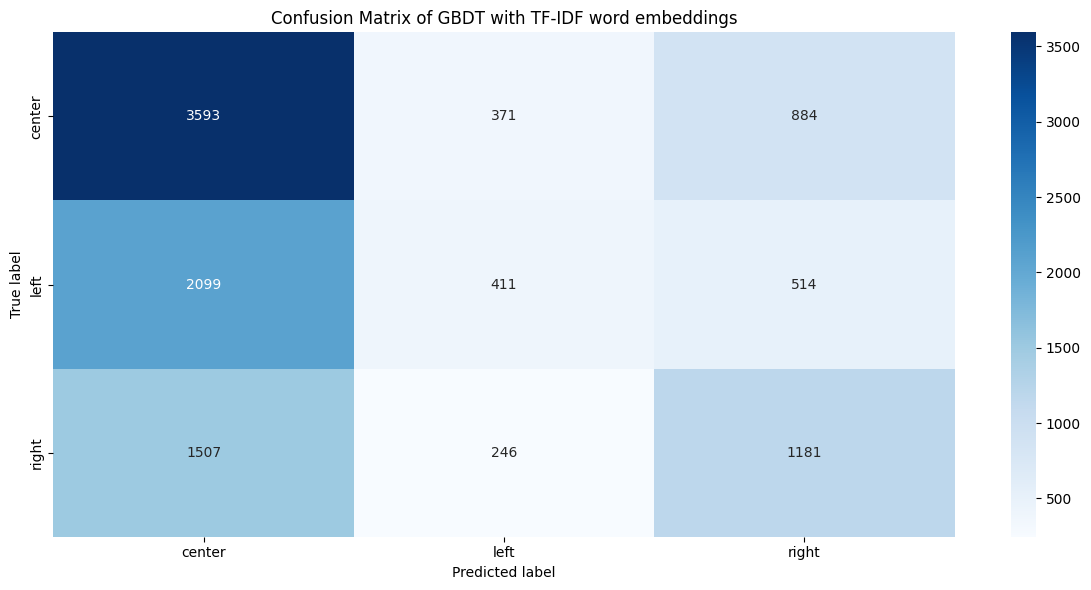

In [ ]:
# Confusion matrix
import numpy as np
import seaborn as sns

class_labels = np.unique(y_test)

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Confusion Matrix of GBDT with TF-IDF word embeddings")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MThesis/cm_gbdt_tfidf.jpg')
plt.show()

### + Word2Vec

In [ ]:
#Getting the data frame
import pandas as pd

X_train_gbdt = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval_word2vec.csv")
X_test_gbdt = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2_word2vec.csv")

def convert_to_float_list(float_str):
    float_str = float_str.replace('[', '').replace(']', '').split()
    float_list = [float(value) for value in float_str]
    return float_list

X_train_gbdt['vec'] = X_train_gbdt['word2vec'].apply(convert_to_float_list)
X_test_gbdt['vec'] = X_test_gbdt['word2vec'].apply(convert_to_float_list)

y_train_pd = X_train_gbdt['political_leaning']
X_train_gbdt = X_train_gbdt['vec'].to_list()
y_train = y_train_pd.values.tolist()

y_test_pd = X_test_gbdt['political_leaning']
X_test_gbdt = X_test_gbdt['vec'].to_list()
y_test = y_test_pd.values.tolist()

In [ ]:
# Importing the libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, f1_score
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [ ]:
# Creating the GBDT model and cross validation
import time
start = time.time()

clf = GradientBoostingClassifier()

scoring = {'accuracy': make_scorer(accuracy_score), 'f1_weighted': make_scorer(f1_score, average='weighted')}
scores = cross_validate(clf, X_train_gbdt, y_train, cv=5, scoring=scoring)

accuracy_scores = scores['test_accuracy']
f1_scores = scores['test_f1_weighted']

avg_accuracy = accuracy_scores.mean()
avg_f1_score = f1_scores.mean()

print("Accuracy scores:", accuracy_scores)
print("F1 weighted scores:", f1_scores)
print("Average accuracy:", avg_accuracy)
print("Average F1 score:", avg_f1_score)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

"""Results:
Accuracy scores: [0.41537941 0.49813959 0.44582253 0.41170501 0.42670275]
F1 weighted scores: [0.39892117 0.45244313 0.42827584 0.39434212 0.40829355]
Average accuracy: 0.439549856979552
Average F1 score: 0.4164551628347608
This code took  125.10521506468454  minutes
"""

Accuracy scores: [0.41537941 0.49813959 0.44582253 0.41170501 0.42670275]
F1 weighted scores: [0.39892117 0.45244313 0.42827584 0.39434212 0.40829355]
Average accuracy: 0.439549856979552
Average F1 score: 0.4164551628347608
This code took  125.10521506468454  minutes


In [ ]:
# Perfomance on test data set
import time
start = time.time()

clf.fit(X_train_gbdt, y_train)
predictions = clf.predict(X_test_gbdt)
print(classification_report(y_test, predictions))

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

              precision    recall  f1-score   support

      center       0.50      0.69      0.58      4848
        left       0.35      0.16      0.22      3024
       right       0.42      0.38      0.40      2934

    accuracy                           0.46     10806
   macro avg       0.42      0.41      0.40     10806
weighted avg       0.43      0.46      0.43     10806

This code took  31.947598572572073  minutes


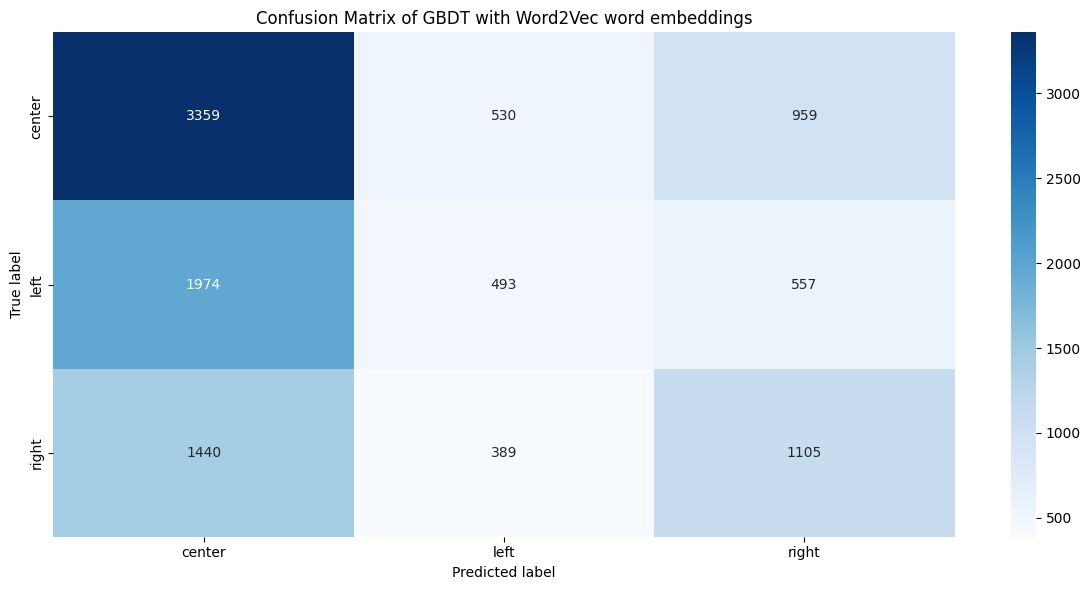

In [ ]:
# Confusion matrix
import numpy as np
import seaborn as sns

class_labels = np.unique(y_test)

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Confusion Matrix of GBDT with Word2Vec word embeddings")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MThesis/cm_gbdt_word2vec.jpg')
plt.show()

### + Big Bird

In [ ]:
#Getting the data frame
X_train_gbdt = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval_bigbird.csv")
X_test_gbdt = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2_bigbird.csv")

X_trainval = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval.csv")
X_test2 = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2.csv")

y_train = X_trainval['political_leaning']
y_test = X_test2['political_leaning']

In [ ]:
# Importing the libraries
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, f1_score
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [ ]:
# Creating the GBDT model and cross validation
import time
start = time.time()

clf = GradientBoostingClassifier()

scoring = {'accuracy': make_scorer(accuracy_score), 'f1_weighted': make_scorer(f1_score, average='weighted')}
scores = cross_validate(clf, X_train_gbdt, y_train, cv=5, scoring=scoring)

accuracy_scores = scores['test_accuracy']
f1_scores = scores['test_f1_weighted']

avg_accuracy = accuracy_scores.mean()
avg_f1_score = f1_scores.mean()

print("Accuracy scores:", accuracy_scores)
print("F1 weighted scores:", f1_scores)
print("Average accuracy:", avg_accuracy)
print("Average F1 score:", avg_f1_score)

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

"""Results:
Accuracy scores: [0.39733905 0.4985906  0.43544932 0.39580514 0.42534957]
F1 weighted scores: [0.37835796 0.45501778 0.42315386 0.375036   0.40616408]
Average accuracy: 0.4305067348001709
Average F1 score: 0.4075459368108453
This code took  298.24827867746353  minutes
"""

Accuracy scores: [0.39733905 0.4985906  0.43544932 0.39580514 0.42534957]
F1 weighted scores: [0.37835796 0.45501778 0.42315386 0.375036   0.40616408]
Average accuracy: 0.4305067348001709
Average F1 score: 0.4075459368108453
This code took  298.24827867746353  minutes


In [ ]:
# Perfomance on test dataset
import time
start = time.time()

clf.fit(X_train_gbdt, y_train)
predictions = clf.predict(X_test_gbdt)
print(classification_report(y_test, predictions))

end = time.time()
time_passed = end - start
print("This code took ", time_passed/60, " minutes")

              precision    recall  f1-score   support

      center       0.49      0.69      0.57      4848
        left       0.39      0.16      0.23      3024
       right       0.42      0.39      0.41      2934

    accuracy                           0.46     10806
   macro avg       0.44      0.41      0.40     10806
weighted avg       0.44      0.46      0.43     10806

This code took  76.47516562541325  minutes


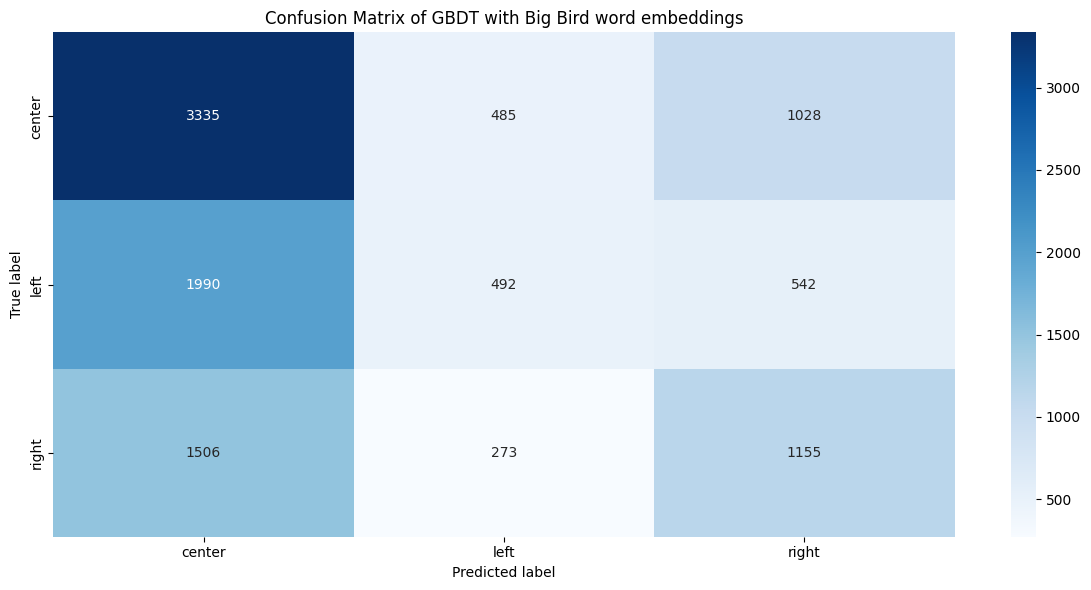

In [ ]:
# Confusion matrix
import numpy as np
import seaborn as sns

class_labels = np.unique(y_test)

cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title("Confusion Matrix of GBDT with Big Bird word embeddings")

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/MThesis/cm_gbdt_bigbird.jpg')
plt.show()

# SHAP values

Reference: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html

In [ ]:
# Install shap
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.0 MB/s eta 0:00:00


In [ ]:
# Import libraries
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, cross_validate
import shap
from shap import Explainer, Explanation
from shap import waterfall_plot
import numpy as np
import matplotlib.pyplot as plt
from shap import force_plot

In [ ]:
# Getting the files and assigning numbers to left, center, and right
import pandas as pd
X_trainval = pd.read_csv("/content/drive/MyDrive/MThesis/X_trainval.csv")
X_test2 = pd.read_csv("/content/drive/MyDrive/MThesis/X_test2.csv")

mapping = {'left': 0, 'center': 1, 'right': 2}

X_trainval['political_leaning'] = X_trainval['political_leaning'].map(mapping)
X_test2['political_leaning'] = X_test2['political_leaning'].map(mapping)

y_train = X_trainval['political_leaning']
y_test = X_test2['political_leaning']


X_train_lg = X_trainval.drop(["auhtor_ID","post","political_leaning","processed_post","corrected_post", "pos"], axis=1)
X_test_lg = X_test2.drop(["auhtor_ID","post","political_leaning","processed_post","corrected_post", "pos"], axis=1)

In [ ]:
# Perfoming logistic regression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, cross_validate
import shap

model = LogisticRegressionCV (cv=5, multi_class='multinomial')
model.fit(X_train_lg, y_train)

y_pred = model.predict(X_test_lg)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [ ]:
y_test_df = y_test.to_frame()
y_pred_df = pd.DataFrame(y_pred)

y_test_df.columns = ['right_political_leaning']
y_pred_df.columns = ['predicted_political_leaning']

In [ ]:
correct_n_predicted = pd.concat([y_test_df, y_pred_df, X_test_lg], axis=1)

In [ ]:
# Taking less values for faster algorithm
backround_test_complete = shap.sample(correct_n_predicted, 2161)
y_test_correct = backround_test_complete['right_political_leaning']
y_test_pred = backround_test_complete['predicted_political_leaning']
backround_test = backround_test_complete.drop(["right_political_leaning","predicted_political_leaning"], axis=1)

In [ ]:
# Getting the shap values
background_train = shap.sample(X_train_lg, 100)

explainer = shap.KernelExplainer(model.predict_proba, background_train, link="logit")

shap_values = explainer(backround_test)

  0%|          | 0/2161 [00:00<?, ?it/s]

In [ ]:
import numpy as np

np.shape(shap_values.values)

(2161, 1312, 3)

In [ ]:
# Getting values for each class
left = shap_values.values[:, :, 0]
center = shap_values.values[:, :, 1]
right = shap_values.values[:, :, 2]

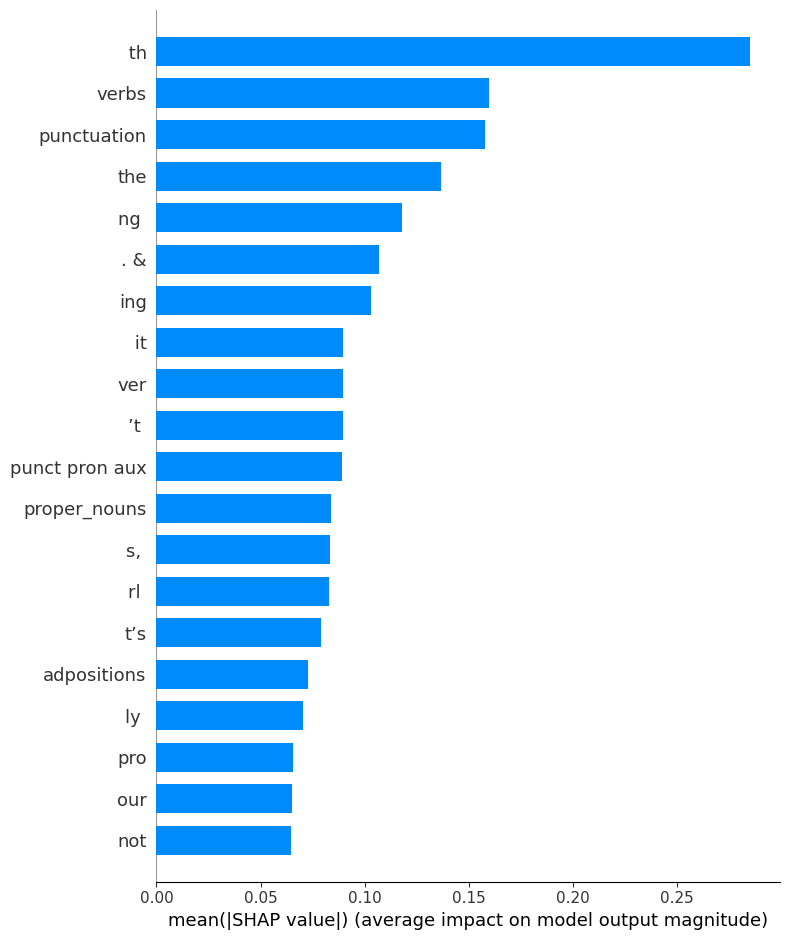

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting left class summary
shap.summary_plot(left, backround_test.values, plot_type="bar", feature_names = backround_test.columns)
plt.savefig('/content/drive/MyDrive/MThesis/left_summary_plot.png', bbox_inches='tight')

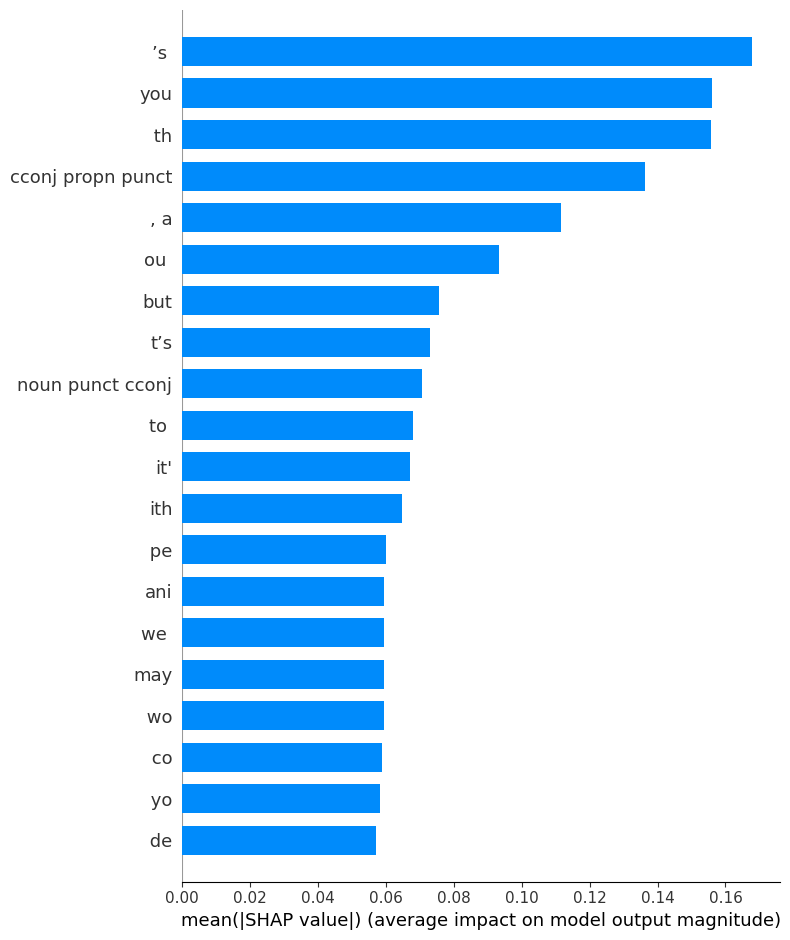

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting center class summary
shap.summary_plot(center, backround_test.values, plot_type="bar", feature_names = backround_test.columns)
plt.savefig('/content/drive/MyDrive/MThesis/center_summary_plot.png', bbox_inches='tight')

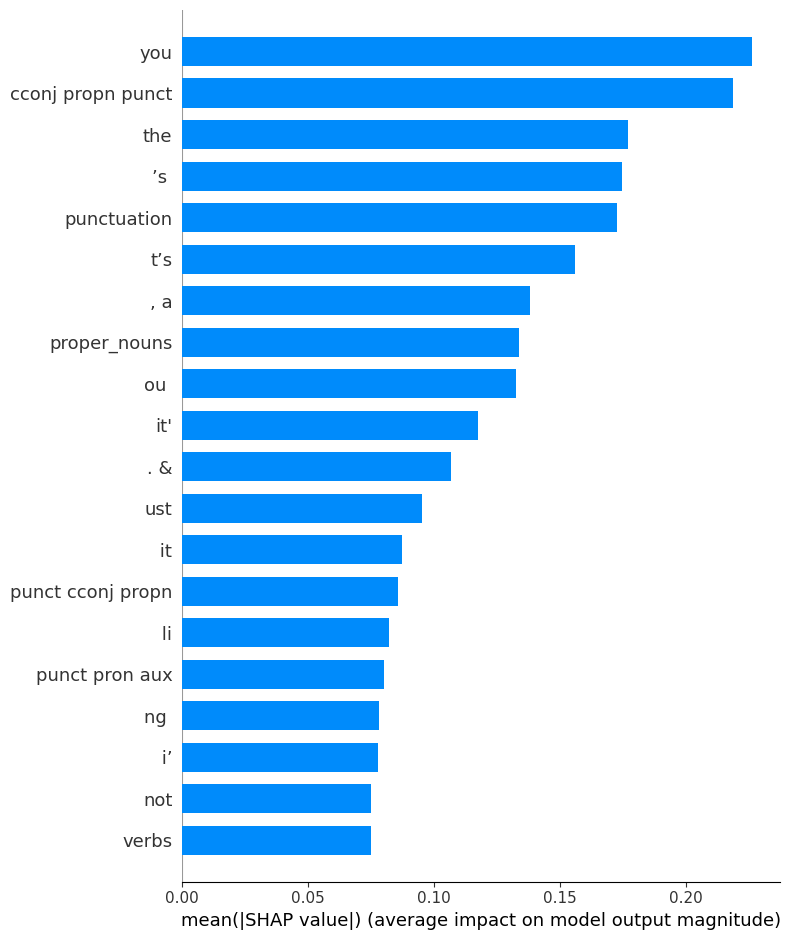

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting right class summary
shap.summary_plot(right, backround_test.values, plot_type="bar", feature_names = backround_test.columns)
plt.savefig('/content/drive/MyDrive/MThesis/right_summary_plot.png', bbox_inches='tight')

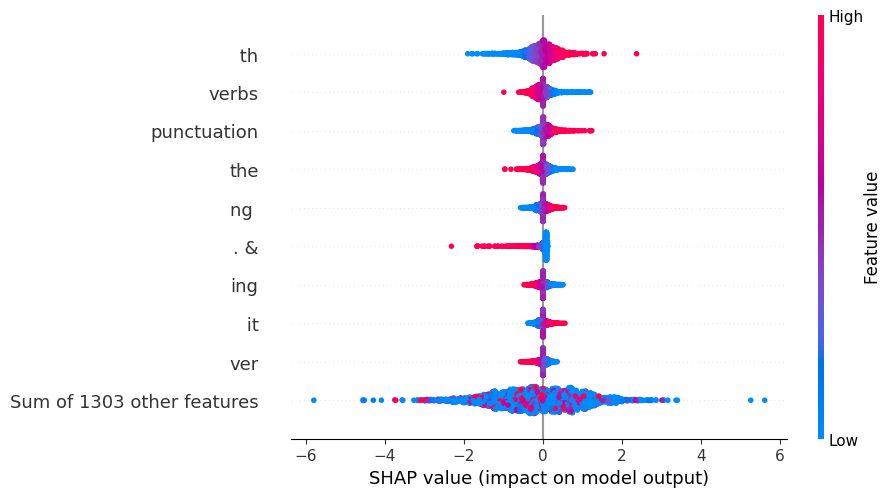

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting left class beeswarm plot
shap.plots.beeswarm(Explanation(left, shap_values.base_values[:,0], backround_test))
plt.savefig('/content/drive/MyDrive/MThesis/left_beeswarm.png', bbox_inches='tight')

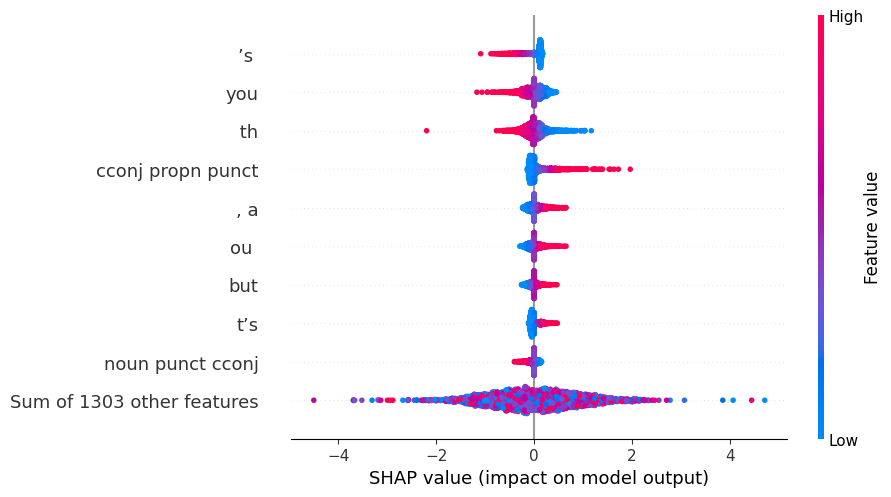

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting center class beeswarm plot
shap.plots.beeswarm(Explanation(center, shap_values.base_values[:,1], backround_test))
plt.savefig('/content/drive/MyDrive/MThesis/center_beeswarm.png', bbox_inches='tight')

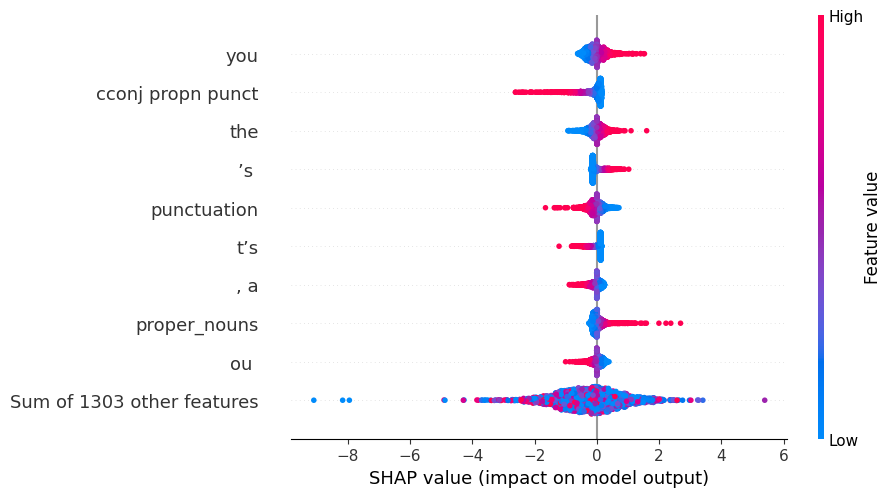

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting right class beeswarm plot
shap.plots.beeswarm(Explanation(right, shap_values.base_values[:,2], backround_test))
plt.savefig('/content/drive/MyDrive/MThesis/right_beeswarm.png', bbox_inches='tight')

In [ ]:
corr_pred_xhap = pd.concat([y_test_correct_shap, y_test_pred_shap], axis=1)

## Explaining seperate entries

### Correct = Left, Predicted = Center

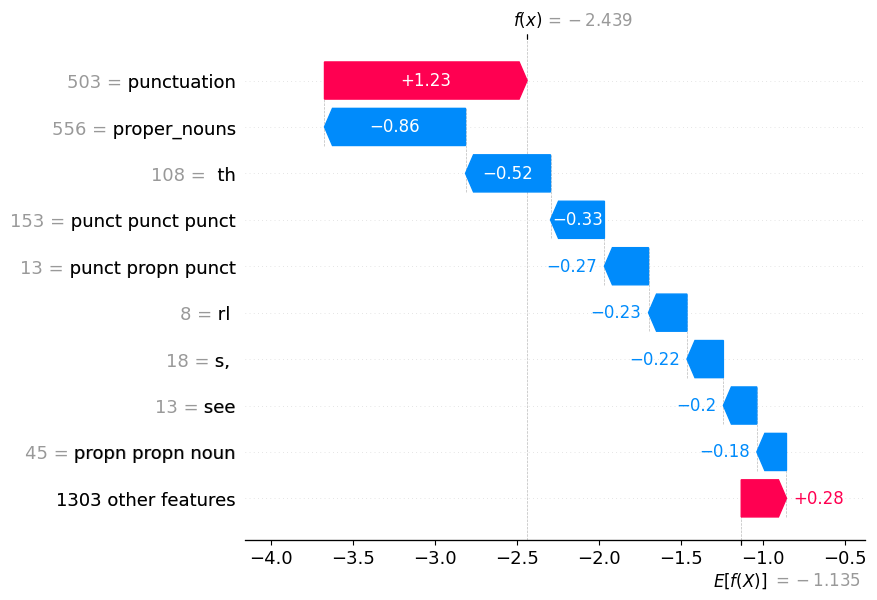

<Figure size 640x480 with 0 Axes>

In [ ]:
"""correct = 0
predicted = 1 """

# Explenation on left class
from shap import Explainer, Explanation
from shap import waterfall_plot

exp = Explanation(left, shap_values.base_values[:,0], backround_test)
idx = 0
waterfall_plot(exp[idx])
plt.savefig('/content/drive/MyDrive/MThesis/left_sample0.png', bbox_inches='tight')

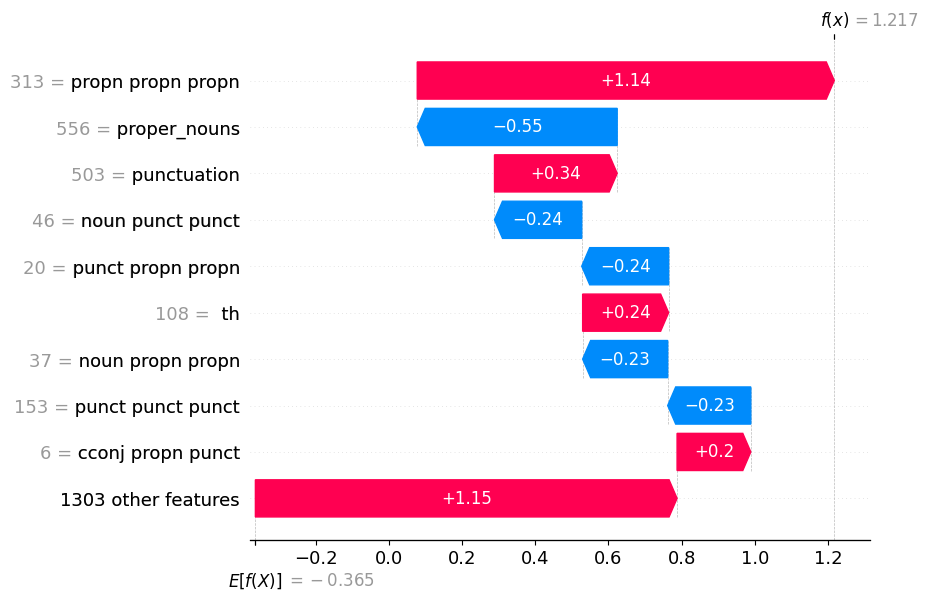

<Figure size 640x480 with 0 Axes>

In [ ]:
# Explenation on center class
exp = Explanation(center, shap_values.base_values[:,1], backround_test)
idx = 0
waterfall_plot(exp[idx])
plt.savefig('/content/drive/MyDrive/MThesis/center_sample0.png', bbox_inches='tight')

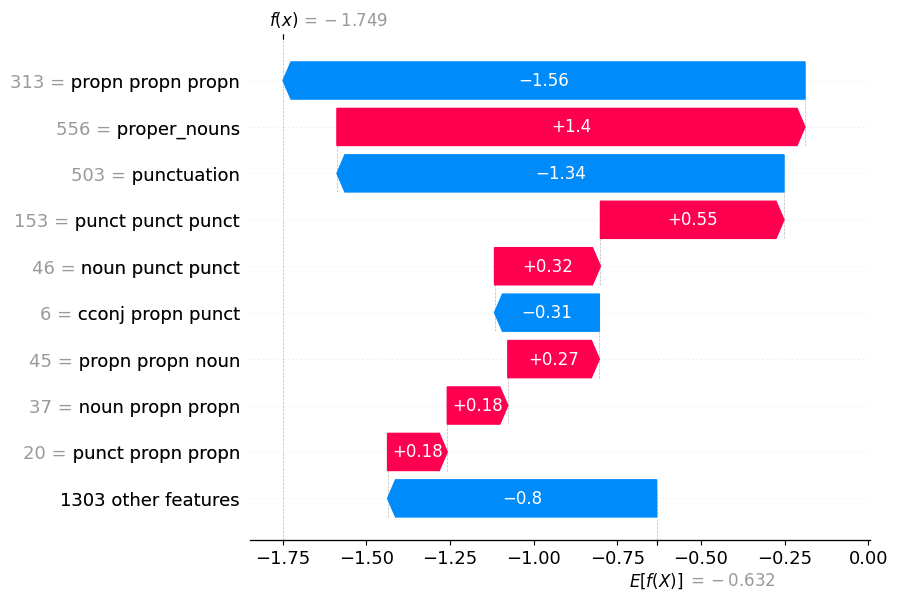

<Figure size 640x480 with 0 Axes>

In [ ]:
# Explenation on right class
exp = Explanation(right, shap_values.base_values[:,2], backround_test)
idx = 0
waterfall_plot(exp[idx])
plt.savefig('/content/drive/MyDrive/MThesis/right_sample0.png', bbox_inches='tight')

### Correct = Predicted = Center

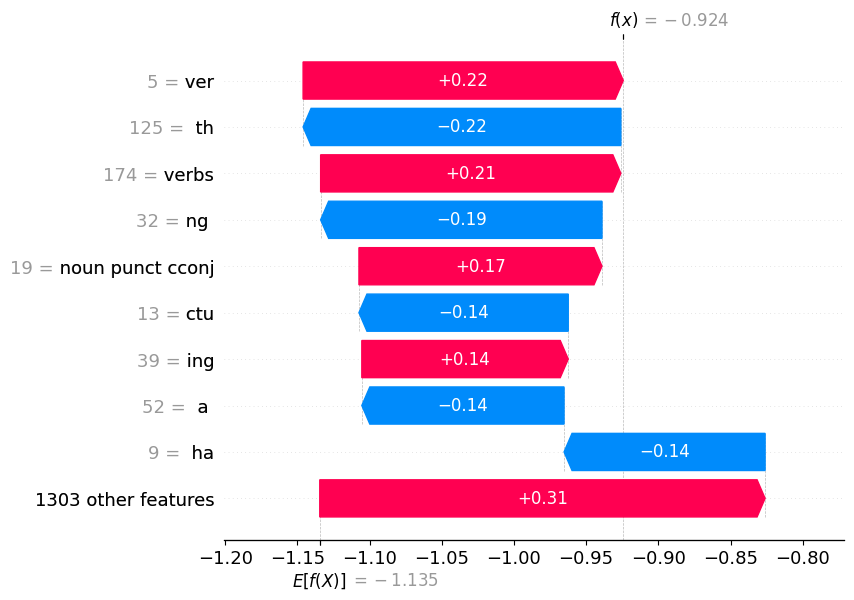

<Figure size 640x480 with 0 Axes>

In [ ]:
"""  predicted = correct = 1"""

# Explenation on left class
from shap import Explainer, Explanation
from shap import waterfall_plot

exp = Explanation(left, shap_values.base_values[:,0], backround_test)
idx = 2
waterfall_plot(exp[idx])
plt.savefig('/content/drive/MyDrive/MThesis/left_sample2.png', bbox_inches='tight')

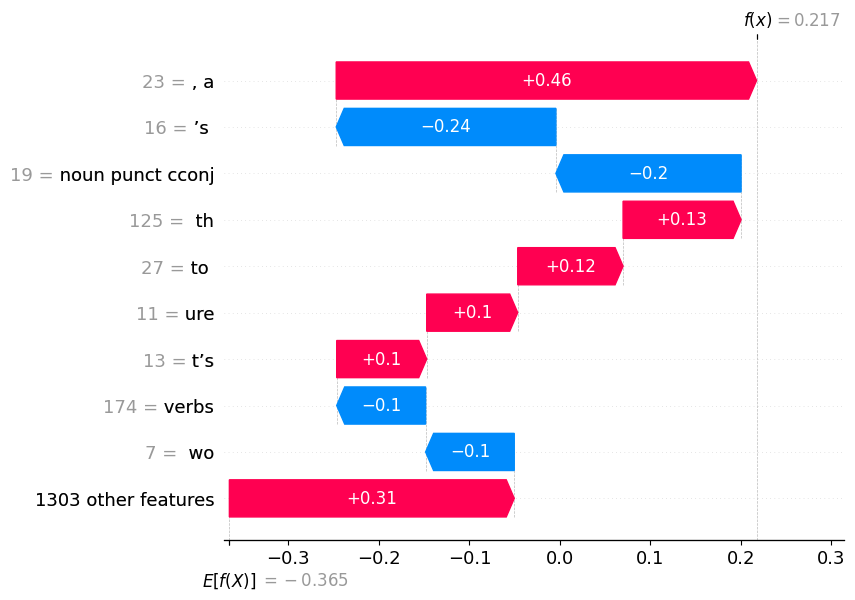

<Figure size 640x480 with 0 Axes>

In [ ]:
# Explenation on center class
exp = Explanation(center, shap_values.base_values[:,1], backround_test)
idx = 2
waterfall_plot(exp[idx])
plt.savefig('/content/drive/MyDrive/MThesis/center_sample2.png', bbox_inches='tight')

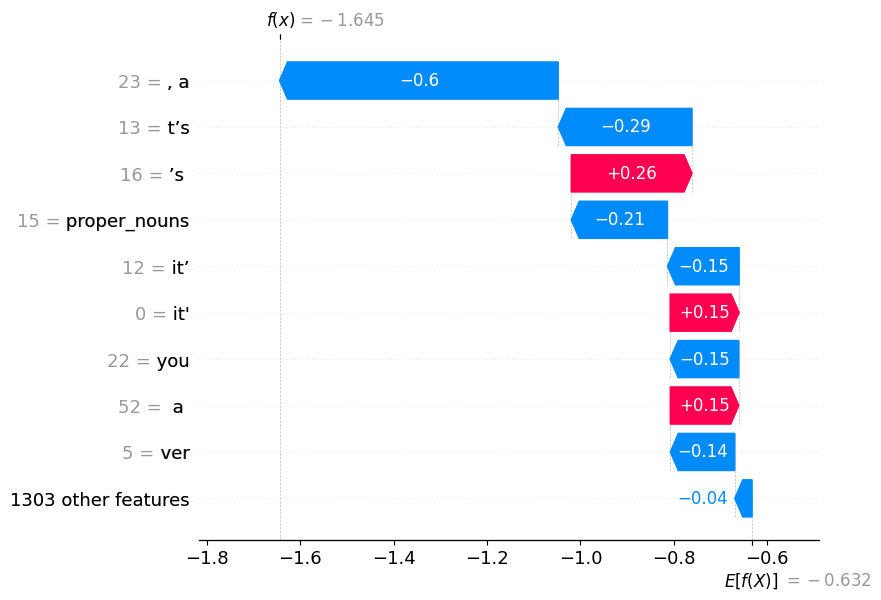

<Figure size 640x480 with 0 Axes>

In [ ]:
# Explenation on right class
exp = Explanation(right, shap_values.base_values[:,2], backround_test)
idx = 2
waterfall_plot(exp[idx])
plt.savefig('/content/drive/MyDrive/MThesis/right_sample2.png', bbox_inches='tight')

### Correct = Right, Predicted = Left

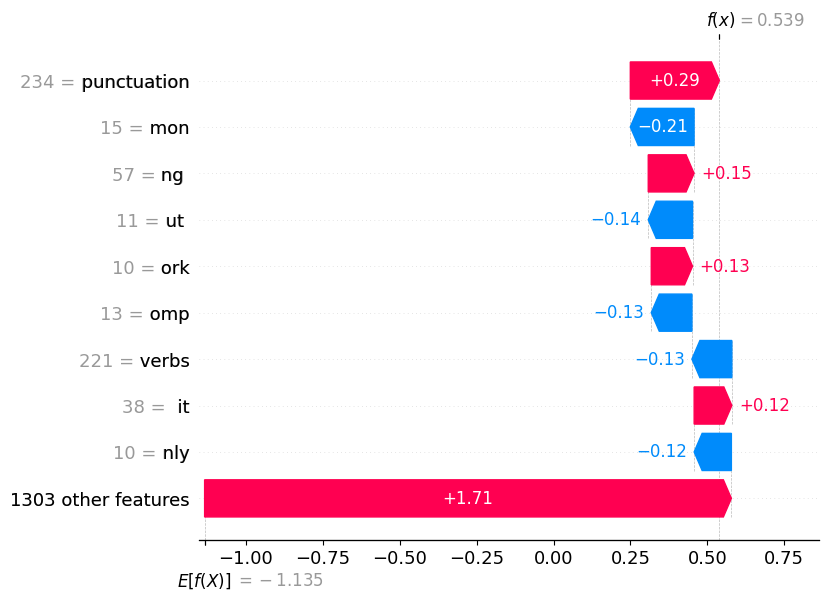

<Figure size 640x480 with 0 Axes>

In [ ]:
"""correct = 2
predicted = 0"""

# Explenation on left class
from shap import Explainer, Explanation
from shap import waterfall_plot

exp = Explanation(left, shap_values.base_values[:,0], backround_test)
idx = 3
waterfall_plot(exp[idx])
plt.savefig('/content/drive/MyDrive/MThesis/left_sample3.png', bbox_inches='tight')

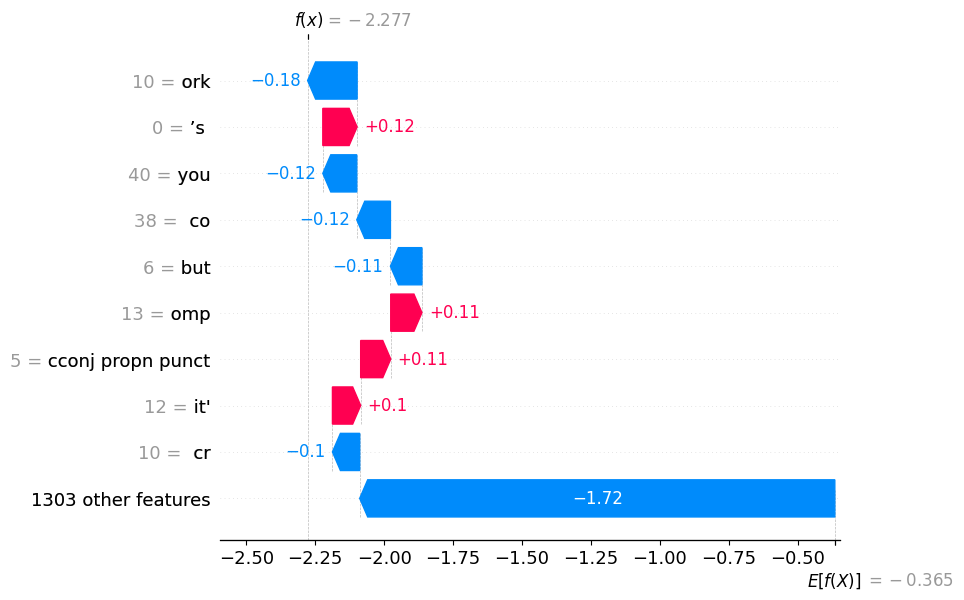

<Figure size 640x480 with 0 Axes>

In [ ]:
# Explenation on center class
exp = Explanation(center, shap_values.base_values[:,1], backround_test)
idx = 3
waterfall_plot(exp[idx])
plt.savefig('/content/drive/MyDrive/MThesis/center_sample3.png', bbox_inches='tight')

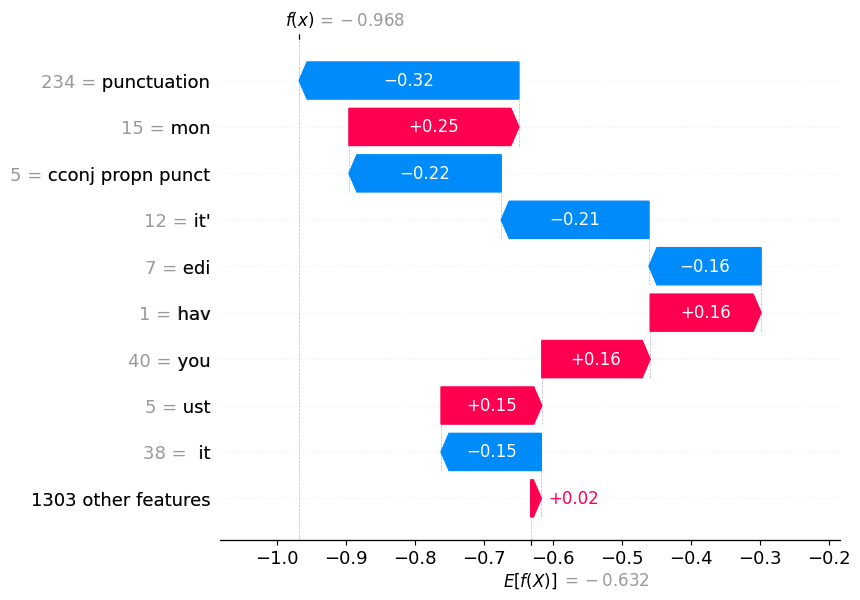

<Figure size 640x480 with 0 Axes>

In [ ]:
# Explenation on right class
exp = Explanation(right, shap_values.base_values[:,2], backround_test)
idx = 3
waterfall_plot(exp[idx])
plt.savefig('/content/drive/MyDrive/MThesis/right_sample3.png', bbox_inches='tight')

### Correct = Center, Predicted = Right

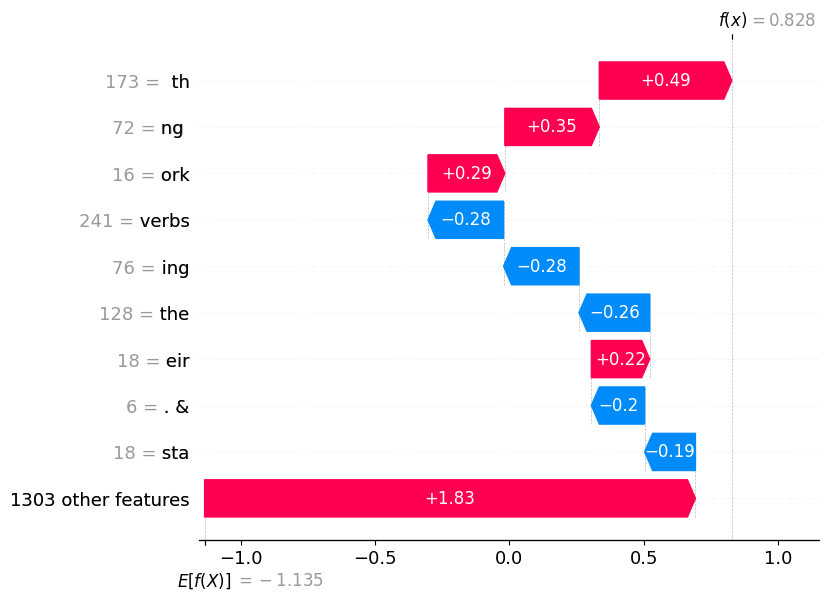

<Figure size 640x480 with 0 Axes>

In [ ]:
"""correct = 1
predicted = 0"""

# Explenation on left class
from shap import Explainer, Explanation
from shap import waterfall_plot

exp = Explanation(left, shap_values.base_values[:,0], backround_test)
idx = 4
waterfall_plot(exp[idx])
plt.savefig('/content/drive/MyDrive/MThesis/left_sample4.png', bbox_inches='tight')

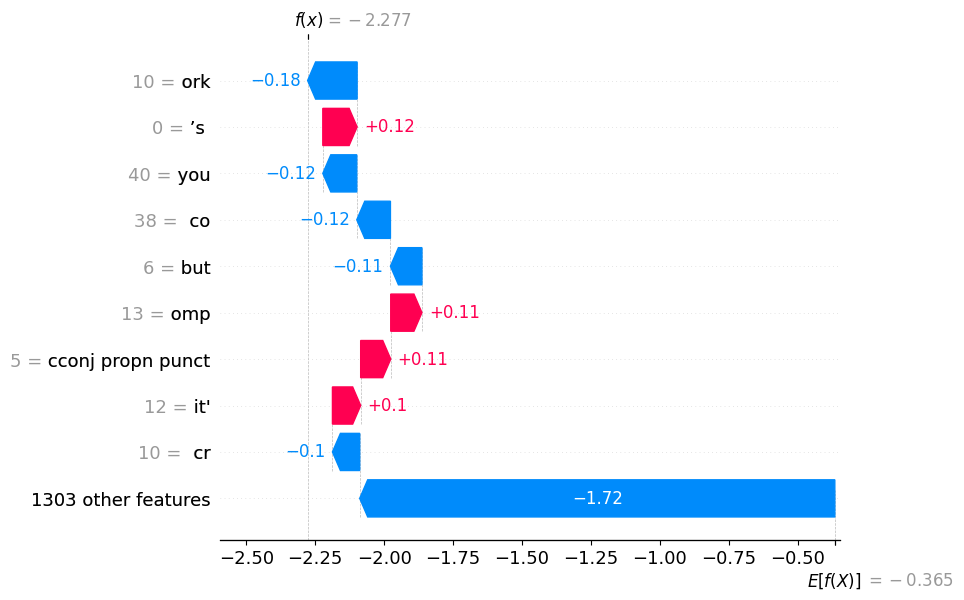

<Figure size 640x480 with 0 Axes>

In [ ]:
# Explenation on center class
exp = Explanation(center, shap_values.base_values[:,1], backround_test)
idx = 3
waterfall_plot(exp[idx])
plt.savefig('/content/drive/MyDrive/MThesis/center_sample3.png', bbox_inches='tight')

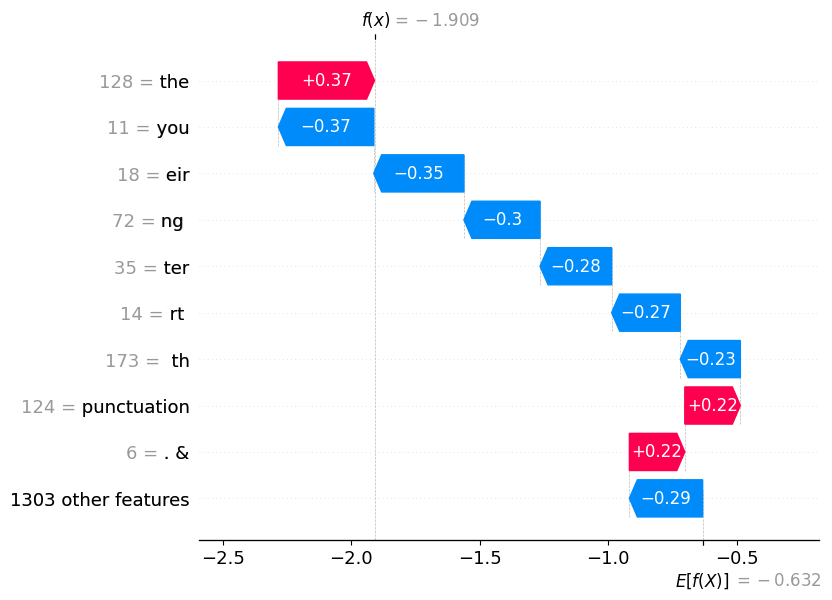

<Figure size 640x480 with 0 Axes>

In [ ]:
# Explenation on right class
exp = Explanation(right, shap_values.base_values[:,2], backround_test)
idx = 4
waterfall_plot(exp[idx])
plt.savefig('/content/drive/MyDrive/MThesis/right_sample4.png', bbox_inches='tight')

### Correct = Predicted = Left

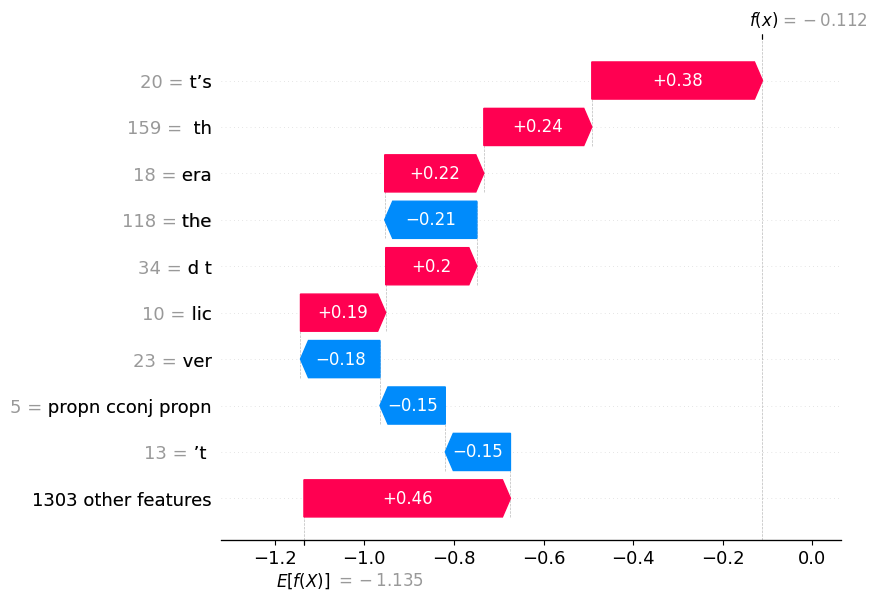

<Figure size 640x480 with 0 Axes>

In [ ]:
"""correct = predicted = 0"""

# Explenation on left class
from shap import Explainer, Explanation
from shap import waterfall_plot

exp = Explanation(left, shap_values.base_values[:,0], backround_test)
idx = 2160
waterfall_plot(exp[idx])
plt.savefig('/content/drive/MyDrive/MThesis/left_sample2160.png', bbox_inches='tight')

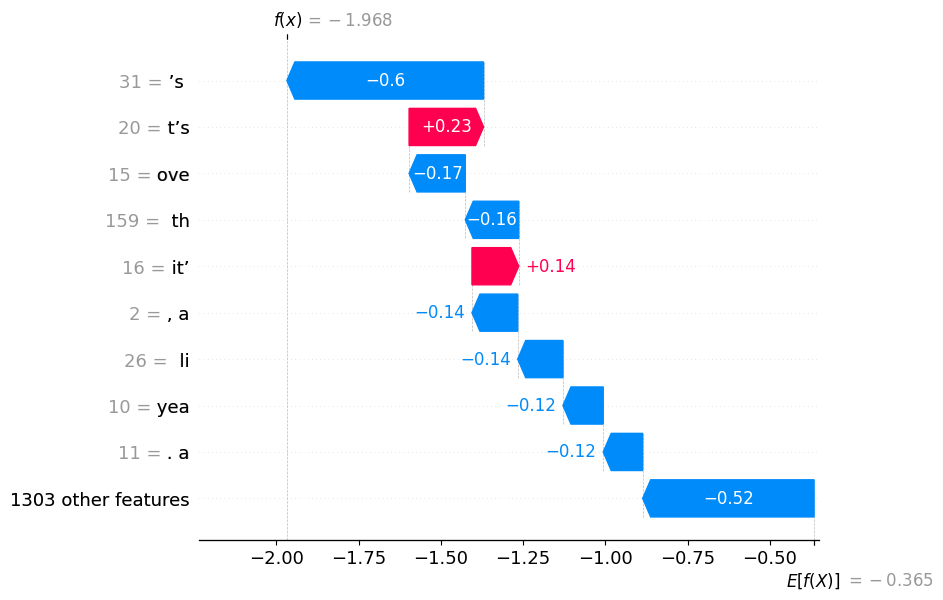

<Figure size 640x480 with 0 Axes>

In [ ]:
# Explenation on center class
exp = Explanation(center, shap_values.base_values[:,1], backround_test)
idx = 2160
waterfall_plot(exp[idx])
plt.savefig('/content/drive/MyDrive/MThesis/center_sample2160.png', bbox_inches='tight')

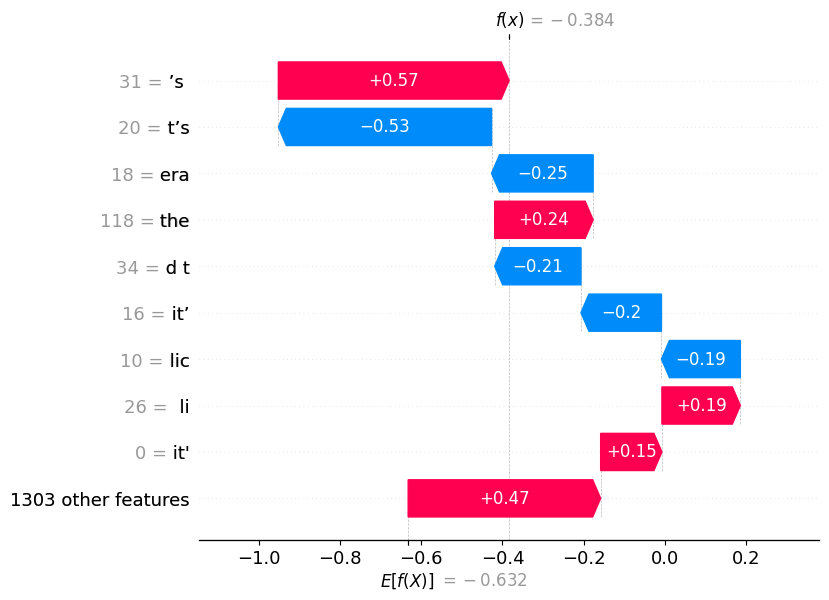

<Figure size 640x480 with 0 Axes>

In [ ]:
# Explenation on right class
exp = Explanation(right, shap_values.base_values[:,2], backround_test)
idx = 2160
waterfall_plot(exp[idx])
plt.savefig('/content/drive/MyDrive/MThesis/right_sample2160.png', bbox_inches='tight')

### Correct = Predicted = Right

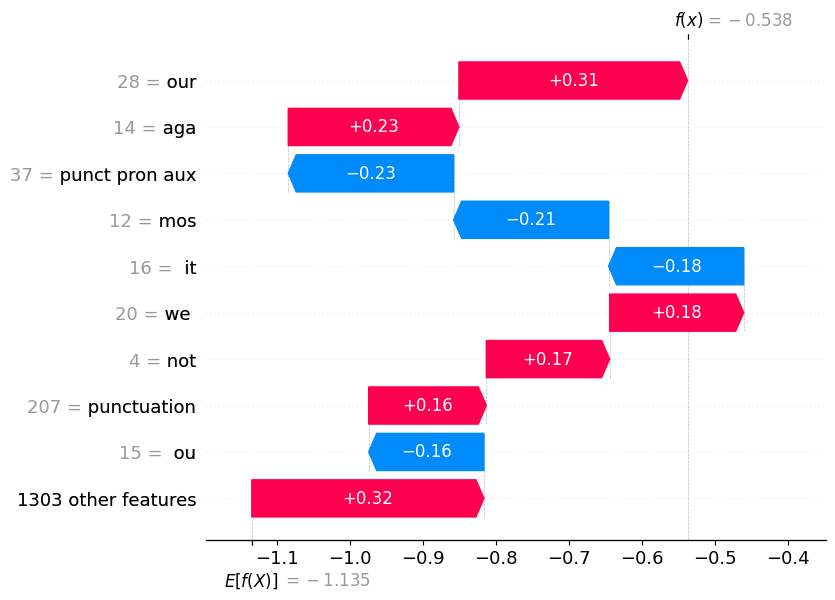

<Figure size 640x480 with 0 Axes>

In [ ]:
"""correct = predicted = 2"""

# Explenation on left class
from shap import Explainer, Explanation
from shap import waterfall_plot

exp = Explanation(left, shap_values.base_values[:,0], backround_test)
idx = 2158
waterfall_plot(exp[idx])
plt.savefig('/content/drive/MyDrive/MThesis/left_sample2158.png', bbox_inches='tight')

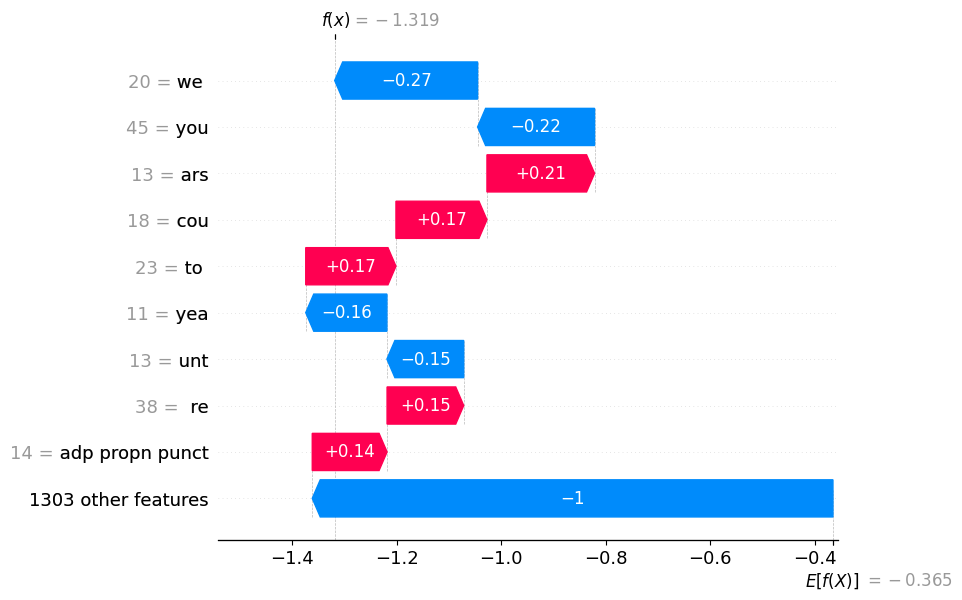

<Figure size 640x480 with 0 Axes>

In [ ]:
# Explenation on center class
exp = Explanation(center, shap_values.base_values[:,1], backround_test)
idx = 2158
waterfall_plot(exp[idx])
plt.savefig('/content/drive/MyDrive/MThesis/center_sample2158.png', bbox_inches='tight')

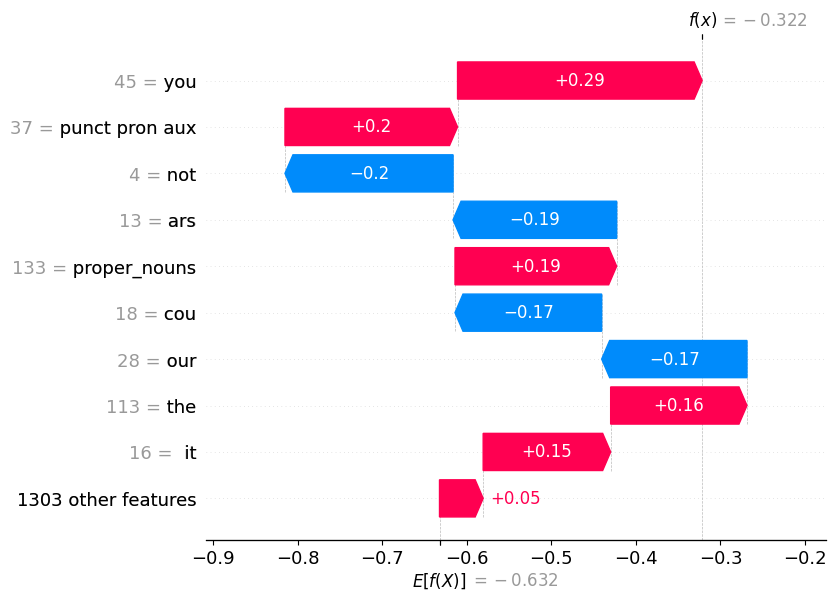

<Figure size 640x480 with 0 Axes>

In [ ]:
# Explenation on right class
exp = Explanation(right, shap_values.base_values[:,2], backround_test)
idx = 2158
waterfall_plot(exp[idx])
plt.show()
plt.savefig('/content/drive/MyDrive/MThesis/right_sample2158.png', bbox_inches='tight')